# NBA Data Analysis
Author: Dr. Goku Moneymaker


## Housekeeping

### Imports

In [38]:
!pip install google-colab-selenium -q

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
import json
import pytz
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from IPython.display import HTML
from bs4 import BeautifulSoup
import time
import google_colab_selenium as gs
import shutil
#from skopt import BayesSearchCV
import os

def download_current_data(date=None):
    # Define the base URL and parameters
    base_url = "https://www.bigdataball.com/wp-admin/admin-ajax.php?action=outofthebox-download"
    account_id = "dbid:AADL0JM6TbjOPoH-7_QmtAYk4iT4-vis0Tk"
    listtoken = "421f46cd8fe7a43b705e438648517e48"

    # Get current date in the required format
    current_date = datetime.now()
    yesterday = current_date - timedelta(1)
    current_date = yesterday.strftime("%m-%d-%Y") if date == None else date
    filename = f"{current_date}-nba-season-team-feed.xlsx"
    outofthebox_path = f"%2F{filename}"

    # Construct the full URL
    full_url = f"{base_url}&OutoftheBoxpath={outofthebox_path}&lastpath=%2F&account_id={account_id}&listtoken={listtoken}&dl=1"

    # Directory to save the file
    save_dir = "./"
    save_path = os.path.join(save_dir, filename)
    print(save_path)

    # don't redownload if we already have it
    if os.path.exists(save_path):
        return filename

    # Use curl to download the file
    response = requests.get(full_url, stream=True)
    print(response.status_code)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
    return filename

column_mappings = {
    "COLS": ['GAME-ID', 'DATE', 'TEAM', '1Q', '2Q', '3Q', '4Q', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'MAIN REF', 'CREW', 'OPENING ODDS', 'OPENING SPREAD', 'OPENING TOTAL', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME'],
    "cleaned_cols": ['Dataset', 'GAME-ID', 'DATE', 'TEAM', 'VENUE', '1Q', '2Q', '3Q', '4Q', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'TO_TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'STARTER_1', 'STARTER_2', 'STARTER_3', 'STARTER_4', 'STARTER_5', 'MAIN REF', 'CREW', 'OPENING ODDS', 'OPENING SPREAD', 'OPENING TOTAL', 'LINE_MOVEMENT_1', 'LINE_MOVEMENT_2', 'LINE_MOVEMENT_3', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME', 'BOX_SCORE_URL', 'ODDS_URL', 'BIGDATABALL_DATASET', 'FULL_GAME_ODDS_URL', 'REFEREE_UMPIRE'],
    "t_cleaned_cols": ['BIGDATABALL_DATASET', 'GAME-ID', 'DATE', 'TEAM', 'VENUE', '1Q', '2Q', '3Q', '4Q', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'TO_TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'STARTER_1', 'STARTER_2', 'STARTER_3', 'STARTER_4', 'STARTER_5', 'MAIN REF', 'CREW', 'OPENING_ODDS', 'OPENING_SPREAD', 'OPENING_TOTAL', 'LINE_MOVEMENT_1', 'LINE_MOVEMENT_2', 'LINE_MOVEMENT_3', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME', 'BOX_SCORE_URL', 'FULL_GAME_ODDS_URL'],
    "TRAIN_COLS": ['CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS'],
    "today_mappings": ['Last_ML_1'],
    "TARGET": 'Result',
    "SEASON_MAP": {'NBA 2021-2022 Regular Season': 2022, 'NBA 2020-2021 Regular Season': 2021, 'NBA 2019-2020 Regular Season': 2020, 'NBA 2022-2023 Regular Season': 2023, 'NBA 2020 Playoffs': 2020, 'NBA 2021 Play-in': 2021, 'NBA 2021 Playoffs': 2021, 'NBA 2023 Play-In': 2023, 'NBA 2022 Play-In': 2022, 'NBA 2023 Playoffs': 2023, 'NBA 2022 Playoffs': 2022, 'NBA 2023-2024 Regular Season': 2024, 'NBA 2023 In-Season Tournament': 2024},
    "t_train_cols": ['CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS','Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS'],
    "train_cols_final": ['CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS','Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS']
}

# To save this as a JSON object, you can use the following code


with open('column_mappings.json', 'w') as file:
    json.dump(column_mappings, file)

with open('column_mappings.json', 'r') as file:
    column_mappings = json.load(file)

# Now, you can access your column lists like this
COLS = column_mappings['COLS']
cleaned_cols = column_mappings['cleaned_cols']
t_cleaned_cols = column_mappings['t_cleaned_cols']
TRAIN_COLS = column_mappings['TRAIN_COLS']
today_mappings = column_mappings['today_mappings']
TARGET = column_mappings['TARGET']
SEASON_MAP = column_mappings['SEASON_MAP']
t_train_cols = column_mappings['t_train_cols']
train_cols_final = column_mappings['train_cols_final']

warnings.filterwarnings('ignore')

### File Downloads

In [24]:
!gdown 1lYgv9vhVq_Exb-alfcz5cpI0j3Gy2OrG
!gdown 1mam7z-vUOw7Xl-AYAyJi5cpBN2TtlcT8
!gdown 1L6A25qq6tmgRGYVvf9bYp2nejZ8eXAgN
!gdown 1sJQL8_eX2bHH1Cybu9kfAMhl5HP-QbXo
!gdown 1h65v-ClnbQkVOnagacMGe4P5V8P3UQPL
!gdown 11xTcuXEnQUh1h3aHxav27LfSx2MpRhop
!gdown 1V8J6jAqTsaa8JhgghvRsmJuatndB_drU
!gdown 13wnnLXB74J1pqG8-H4S8mlcvH4ijLCVq
!gdown 1vEjIA-BorLQChUngI0CEouhXZb6Tehcs
!gdown 14D8MejI6MGtRTV-WsP2kLSMnZmWHe4qC

TODAY_FILE = download_current_data(date='12-21-2023')
# TODAY_FILE
# df = pd.read_csv('NBA_Data_Processed.csv')
# df['DATE'] = df['DATE'].astype('datetime64[ns]')
# df = df.sort_values('DATE')
# df.tail(10)[COLS]

Downloading...
From: https://drive.google.com/uc?id=1lYgv9vhVq_Exb-alfcz5cpI0j3Gy2OrG
To: /content/2020-2021.csv
100% 8.87k/8.87k [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mam7z-vUOw7Xl-AYAyJi5cpBN2TtlcT8
To: /content/2019-2020.csv
100% 8.47k/8.47k [00:00<00:00, 27.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L6A25qq6tmgRGYVvf9bYp2nejZ8eXAgN
To: /content/2021_2022.csv
100% 9.09k/9.09k [00:00<00:00, 23.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sJQL8_eX2bHH1Cybu9kfAMhl5HP-QbXo
To: /content/2018-2019.csv
100% 6.91k/6.91k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h65v-ClnbQkVOnagacMGe4P5V8P3UQPL
To: /content/2022-2023.csv
100% 11.9k/11.9k [00:00<00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=11xTcuXEnQUh1h3aHxav27LfSx2MpRhop
To: /content/2018-2019_NBA_Box_Score_Team-Stats.xlsx
100% 1.06M/1.06M [00:00<00:00, 52.6MB/s]
Downloading...
From: https://drive.google.com/uc?i

#### Pull live odds and refs

#### Get the odds

In [39]:
def scrape_dynamic_content(url, delay=10):
    # Initialize the WebDriver

    driver = gs.Chrome()

    # Navigate to the URL
    driver.get(url)

    # Wait for JavaScript to load
    time.sleep(delay)

    # Get the HTML content of the page
    html_content = driver.page_source

    # Close the browser
    driver.quit()

    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all relevant div elements
    elements = soup.find_all('div', class_='flex p-0')

    data = []

    for element in elements:
        try:
            team_info = element.find('button', {'data-testid': 'team-name'})
            if team_info:
                team_name = team_info.find('div', class_='text-primary text-description text-primary').get_text(strip=True)
                team_stats = team_info.find('div', class_='text-subdued-primary mt-0.5 text-footnote').get_text(strip=True)

            bets = element.find_all('button', {'data-dd-action-name': 'Add Bet Selections'})
            bet_data = []
            for bet in bets:
                bet_text = bet.get_text(strip=True).split()
                bet_type = bet_text[0] if bet_text else None
                bet_value = bet_text[1] if len(bet_text) > 1 else None
                bet_data.append({'type': bet_type, 'value': bet_value})

            data.append({'team_name': team_name, 'team_stats': team_stats, 'bets': bet_data})
        except:
          pass

    return data

# URL of the page to scrape
url = 'https://espnbet.com/sport/basketball/organization/united-states/competition/nba/featured-page'  # Replace with the actual URL

# Scrape the dynamic content
scraped_data = scrape_dynamic_content(url)
print('DONE')


<IPython.core.display.Javascript object>

DONE


#### Process that into the format we need

In [40]:
def process_betting_data(data, team_city_map):
    output = {}
    for i, item in enumerate(data):
        city = team_city_map.get(item['team_name'], 'Unknown City')
        bets = item['bets']

        opp_ind = i - 1 if i%2 == 1 else i + 1
        venue = 'H' if i % 2 == 1 else 'R'

        # Initialize default values
        moneyline = spread = total = 'BLANK_STRING'

        # Extract the moneyline, spread, and total from the bets
        if bets:
            # Moneyline is the value of 'type' in the last object
            moneyline = bets[-1]['type'] if bets[-1]['value'] is None else bets[-1]['value']

            # Spread is the value before the '-' in the first object
            spread_data = bets[0]['type'][:4] if bets[0]['type'] else ''
            spread = spread_data if spread_data else 'BLANK_STRING'

            # Total is the value before the '-' in the second object
            total_data = bets[1]['value'].split('-')[0] if len(bets) > 1 and bets[1]['value'] else ''
            total = total_data if total_data else 'BLANK_STRING'

        # Construct the output format
        if city not in output:
          output[city] = ['REF', moneyline, venue, team_city_map.get(data[opp_ind]['team_name']), spread, total]

    return output

team_city_map = {
    'ATL Hawks': 'Atlanta',
    'BKN Nets': 'Brooklyn',
    'BOS Celtics': 'Boston',
    'CHA Hornets': 'Charlotte',
    'CHI Bulls': 'Chicago',
    'CLE Cavaliers': 'Cleveland',
    'DAL Mavericks': 'Dallas',
    'DEN Nuggets': 'Denver',
    'DET Pistons': 'Detroit',
    'GS Warriors': 'Golden State',
    'HOU Rockets': 'Houston',
    'IND Pacers': 'Indiana',
    'LA Clippers': 'LA Clippers',
    'LA Lakers': 'LA Lakers',
    'L.A. Lakers': 'LA Lakers',
    'MEM Grizzlies': 'Memphis',
    'MIA Heat': 'Miami',
    'MIL Bucks': 'Milwaukee',
    'MIN Timberwolves': 'Minnesota',
    'NO Pelicans': 'New Orleans',
    'NY Knicks': 'New York',
    'OKC Thunder': 'Oklahoma City',
    'ORL Magic': 'Orlando',
    'PHI 76ers': 'Philadelphia',
    'PHX Suns': 'Phoenix',
    'POR Trail Blazers': 'Portland',
    'SAC Kings': 'Sacramento',
    'SA Spurs': 'San Antonio',
    'TOR Raptors': 'Toronto',
    'UTA Jazz': 'Utah',
    'WSH Wizards': 'Washington'
}

processed_data = process_betting_data(scraped_data, team_city_map)
print('DONE')

DONE


#### get today's refs and merge that in

In [41]:
def parse_referee_data(html_content, team_city_map):
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='table')
    rows = table.find_all('tr')[1:]  # Skipping the header row

    ref_data = {}
    for row in rows:
        columns = row.find_all('td')
        if len(columns) < 4:
            continue  # Skip rows that don't have enough columns

        game = columns[0].get_text(strip=True)
        crew_chief = columns[1].get_text(strip=True)
        referee = columns[2].get_text(strip=True)
        umpire = columns[3].get_text(strip=True)

        # Split the game into two teams
        teams = game.split(' @ ')
        if len(teams) != 2:
            continue  # Skip if format is not as expected
        city1 = teams[0] #_city_map.get(teams[0].split()[-1] + " " + teams[0].split()[-2], "Unknown")
        city2 = teams[1] #_city_map.get(teams[1].split()[-1] + " " + teams[1].split()[-2], "Unknown")

        ref_data[city1] = [crew_chief, referee, umpire]
        ref_data[city2] = [crew_chief, referee, umpire]

    return ref_data

driver = gs.Chrome()
driver.get('https://official.nba.com/referee-assignments/')

# Wait for JavaScript to load
time.sleep(10)

# Get the HTML content of the page
html_content = driver.page_source

# Close the browser
driver.quit()


referee_data = parse_referee_data(html_content, team_city_map)

for city, refs in referee_data.items():
    try:
        if city == 'L.A. Lakers':
          city = 'LA Lakers'
        processed_data[city][0] = ' '.join(refs[0].split(' ')[:-1])
        #print(f"{city}: {refs[0].split(' ')[:-1].join(' ')}")
    except:
      pass

def remove_ref_keys(data_dict):
    return {k: v for k, v in data_dict.items() if v[0] != 'REF'}

processed_data = remove_ref_keys(processed_data)
TODAY_MAP = processed_data
display(processed_data)
print('DONE')

<IPython.core.display.Javascript object>

{'Toronto': ['Courtney Kirkland',
  '+275',
  'R',
  'Philadelphia',
  '+8.5',
  '230.5'],
 'Philadelphia': ['Courtney Kirkland',
  '-355',
  'H',
  'Toronto',
  '-8.5',
  '230.5'],
 'Denver': ['Marc Davis', '-180', 'R', 'Brooklyn', '-4.5', '230.5'],
 'Brooklyn': ['Marc Davis', '+150', 'H', 'Denver', '+4.5', '230.5'],
 'Atlanta': ['Scott Foster', 'Even', 'R', 'Miami', '+1.5', '238.5'],
 'Miami': ['Scott Foster', '-120', 'H', 'Atlanta', '-1.5', '238.5'],
 'Dallas': ['Karl Lane', '+260', 'R', 'Houston', '+8.5', '223.5'],
 'Houston': ['Karl Lane', '-325', 'H', 'Dallas', '-8.5', '223.5'],
 'Phoenix': ['Josh Tiven', '+135', 'R', 'Sacramento', '+3.5', '243.5'],
 'Sacramento': ['Josh Tiven', '-155', 'H', 'Phoenix', '-3.5', '243.5'],
 'Washington': ['Ben Taylor', '+450', 'R', 'Golden State', '+11.', '247.5'],
 'Golden State': ['Ben Taylor', '-625', 'H', 'Washington', '-11.', '247.5']}

DONE


### Build dataframe

In [46]:
team_df_2019 = pd.read_excel('2018-2019_NBA_Box_Score_Team-Stats.xlsx')
team_df_2020 = pd.read_excel('2019-2020_NBA_Box_Score_Team-Stats.xlsx')
team_df_2021 = pd.read_excel('2020-2021_NBA_Box_Score_Team-Stats.xlsx')
team_df_2022 = pd.read_excel('2021-2022_NBA_Box_Score_Team-Stats.xlsx')
team_df_2023 = pd.read_excel('2022-2023_NBA_Box_Score_Team-Stats.xlsx')
tdf = pd.read_excel(TODAY_FILE)
refs_2019 = pd.read_csv('2018-2019.csv')
refs_2020 = pd.read_csv('2019-2020.csv')
refs_2021 = pd.read_csv('2020-2021.csv')
refs_2022 = pd.read_csv('2021_2022.csv')
refs_2023 = pd.read_csv('2022-2023.csv')
refs_2024 = pd.read_csv('2023-2024.csv')

refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023, refs_2024])
df = pd.concat([team_df_2019, team_df_2020, team_df_2021, team_df_2022, team_df_2023])
df.columns = cleaned_cols
tdf.columns = t_cleaned_cols

rename_map = {
    'OPENING_ODDS': 'OPENING ODDS',
    'FULL_GAME_ODDS_URL': 'ODDS_URL'
    # Add other mappings if there are more discrepancies
}
tdf.rename(columns=rename_map, inplace=True)

# Step 2: Add missing columns in df2 (if any)
missing_cols = set(cleaned_cols) - set(tdf.columns)
for col in missing_cols:
    tdf[col] = pd.NA


#Step 3: Concatenate the DataFrames
df = pd.concat([df, tdf], ignore_index=True)
""" Add additional columns to games df """
df['Season'] = df['BIGDATABALL_DATASET'].map(SEASON_MAP)

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    group['CREW'] = [group['CREW'].iloc[0]]*2
    #group['Covered_Spread'] = (group['F'] + group['CLOSING_SPREAD'] >= (group['CLOSING_SPREAD'] + group[''] )*1

    # t1_spread_f = group.iloc[0]['F'] + group.iloc[0]['CLOSING_SPREAD']
    # t2_spread_f = group.iloc[1]['F'] + group.iloc[1]['CLOSING_SPREAD']
    # res = [t1_spread_f > group.iloc[1]['F'], t2_spread_f > group.iloc[0]['F']]
    # group['Covered_Spread'] =

    group['Result'] = (group['F'].sum() > group.iloc[0]['CLOSING_TOTAL'])*1

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
df['Avg_3_game_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_PTS'] = df.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

df['Avg_3_game_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_POSS'] = df.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

df['Avg_3_game_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_PACE'] = df.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

df['Avg_3_game_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_OEFF'] = df.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

df['Avg_3_game_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
df['Avg_5_game_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
df['Season_Avg_DEFF'] = df.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')


# Apply the function to each game group
df = df.groupby('GAME-ID').apply(assign_results)
# Reset index if needed
df.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
df['Prev_Result'] = df.groupby(['TEAM', 'Season'])['Result'].shift()

# Step 3: Win/Loss Streak
def calculate_streak(group):
    streak = 0
    streaks = []
    for result in group['Prev_Result']:
        if result == 1:
            streak = streak + 1 if streak > 0 else 1
        else:
            streak = streak - 1 if streak < 0 else -1
        streaks.append(streak)
    group['Streak'] = streaks
    return group

df = df.groupby(['TEAM', 'Season']).apply(calculate_streak)
# Step 4: Last 3 Games Moneylines
df['Last_ML_1'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(1)
df['Last_ML_2'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(2)
df['Last_ML_3'] = df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(3)
# Step 5: Current Number of Wins - Losses
df['Wins'] = df.groupby(['TEAM', 'Season'])['Result'].cumsum()
df['Losses'] = df.groupby(['TEAM', 'Season'])['Result'].transform('count') - df['Wins']
df['Win_Loss_Diff'] = df['Wins'] - df['Losses']

#Step 6: Current Opponent
df['Opponent'] = df.groupby('GAME-ID')['TEAM'].shift(-1).fillna(df.groupby('GAME-ID')['TEAM'].shift())

#Clean up and remove the temporary 'Prev_Result' column
df.drop('Prev_Result', axis=1, inplace=True)
df = df.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')
df['DATE'] = df['DATE'].astype('datetime64[ns]')
df = df.sort_values('DATE')
df.tail(10)[COLS]

,GAME-ID,DATE,TEAM,1Q,2Q,3Q,4Q,F,MIN,FG,...,MAIN REF,CREW,OPENING ODDS,OPENING SPREAD,OPENING TOTAL,CLOSING_ODDS,CLOSING_SPREAD,CLOSING_TOTAL,MONEYLINE,HALFTIME
10729,22300378,2023-12-21,Milwaukee,28,31,32,27,118,240.0,38,...,Eric Dalen,Mark Lindsay,-8.5 -05,NaN,NaN,-8.5 -14,-8.5,238.0,-360,-5 -05
10724,22300375,2023-12-21,New Orleans,36,30,28,29,123,240.0,47,...,Tony Brothers,Che Flores,227.5o -15,NaN,NaN,-3.5 -10,-3.5,225.0,-164,-2
10727,22300379,2023-12-21,Oklahoma City,35,29,45,25,134,240.0,51,...,Michael Smith,Bill Kennedy,-4.5 -10,NaN,NaN,-6 -12,-6.0,237.5,-235,-2.5
10726,22300379,2023-12-21,LA Clippers,29,30,33,23,115,240.0,44,...,Michael Smith,Bill Kennedy,233.5o -10,NaN,NaN,237.5o -10,6.0,237.5,+194,120o 11
10725,22300375,2023-12-21,Cleveland,28,24,24,28,104,240.0,41,...,Tony Brothers,Che Flores,-.5 -15,NaN,NaN,225u -10,3.5,225.0,+138,114.5
10723,22300374,2023-12-21,Detroit,32,26,30,23,111,240.0,43,...,Zach Zarba,Dannica Mosher,238.5o -10,NaN,NaN,-2 -12,-2.0,233.0,-132,-2 -15
10722,22300374,2023-12-21,Utah,34,30,26,29,119,240.0,43,...,Zach Zarba,Dannica Mosher,-1.5 -10,NaN,NaN,233o -12,2.0,233.0,+112,119
10736,22300381,2023-12-21,Washington,33,34,26,25,118,240.0,42,...,Sean Wright,Mitchell Ervin,240.5o -10,NaN,NaN,239.5o -08,4.0,239.5,+142,124o 11
10728,22300378,2023-12-21,Orlando,31,25,26,32,114,240.0,45,...,Eric Dalen,Mark Lindsay,239.5u -15,NaN,NaN,238o -10,8.5,238.0,+290,115.5
10737,22300381,2023-12-21,Portland,24,30,26,37,117,240.0,43,...,Sean Wright,Mitchell Ervin,-3.5 -10,NaN,NaN,-4 -10,-4.0,239.5,-168,-5.5


#### missing data viz

Total missing values per column:
 Dataset                                                        10248
GAME-ID                                                            0
DATE                                                               0
TEAM                                                               0
VENUE                                                              0
                                                               ...  
TOTAL POINTS PER GAME                                              0
CALLED FOULS PER GAME                                              0
FOUL% AGAINST ROAD TEAMS                                           0
FOUL% AGAINST HOME TEAMS                                           0
FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)        0
Length: 85, dtype: int64

Percentage of missing values per column:
 Dataset                                                        100.0
GAME-ID                                                          0.0
D

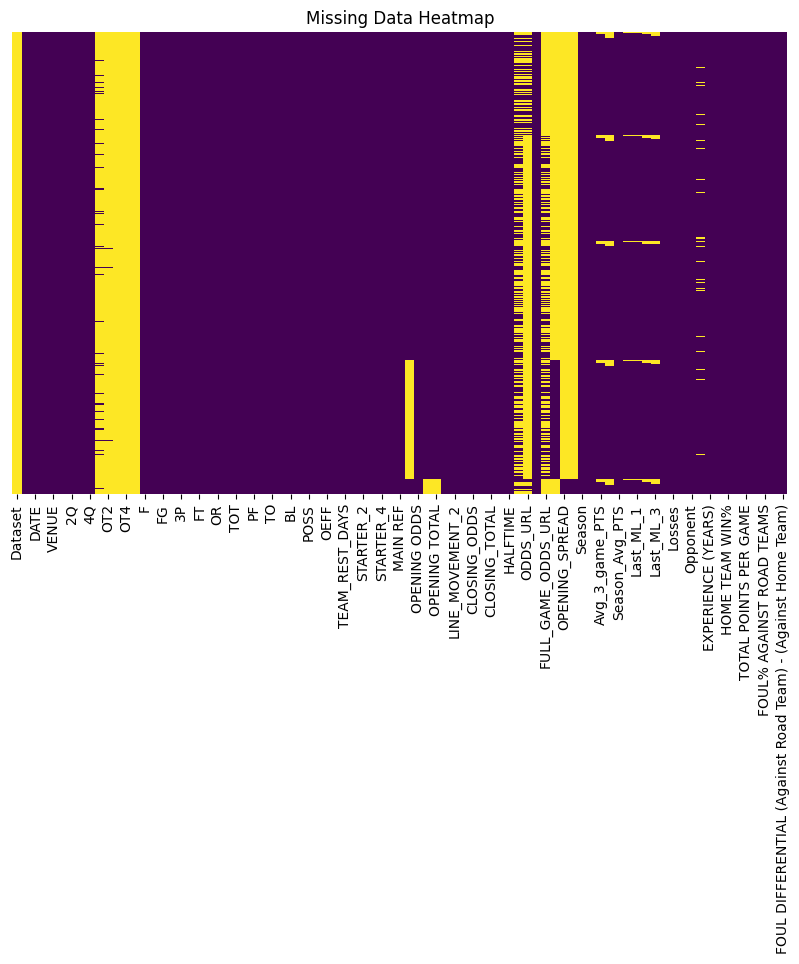

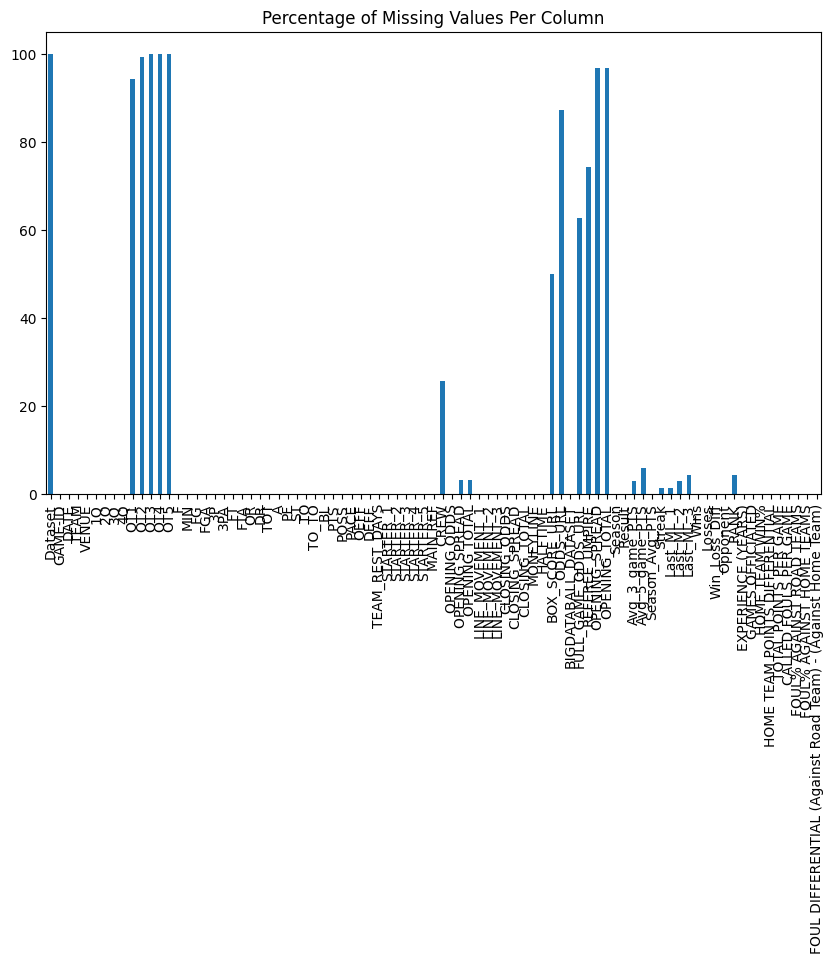

In [ ]:
total_missing = df.isna().sum()
print("Total missing values per column:\n", total_missing)

# 2. Percentage of missing values per column
percent_missing = (df.isna().sum() / len(df)) * 100
print("\nPercentage of missing values per column:\n", percent_missing)

# 3. Visualization of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# If you prefer a bar plot
plt.figure(figsize=(10, 6))
percent_missing.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.show()

#### Create ELO and Momentum Columns

We calculate the expected probability of a team winning as:

$$ \frac{1}{1 + 10^{\frac{opp\_elo - elo}{400}}} $$

Then update that team's elo with the result as:

$$ elo_{t+1} = elo_t +  $$

In [47]:
# Initialize Elo ratings and momentum scores
elo_ratings = {team: 1500 for team in df['TEAM'].unique()}
momentum_scores = {team: 0 for team in df['TEAM'].unique()}
K = 10  # K-factor in Elo rating
m = 1.2 # m factor in momentup
momentum_decay = 0.9  # Decay factor for momentum

def update_elo_momentum(row):
    team = row['TEAM']
    opponent = df[(df['GAME-ID'] == row['GAME-ID']) & (df['TEAM'] != team)]['TEAM'].values[0]
    team_elo, opponent_elo = elo_ratings[team], elo_ratings[opponent]

    # Calculate expected outcomes
    expected_team = 1 / (1 + 10 ** ((opponent_elo - team_elo) / 400))

    # Actual outcome
    actual_team = row['Result']

    # Update Elo ratings
    elo_ratings[team] += K * (actual_team - expected_team)
    #elo_ratings[opponent] += K * ((1 - actual_team) - (1 - expected_team))

    # Calculate Elo difference
    elo_diff = abs(opponent_elo - team_elo)

    # Update momentum
    momentum_scores[team] = momentum_decay * (momentum_scores[team] + elo_diff) if actual_team == 1 else momentum_decay * (momentum_scores[team] - (elo_diff/m))

    return elo_ratings[team], momentum_scores[team]

# Apply the function
df[['Elo_Rating', 'Momentum']] = df.apply(update_elo_momentum, axis=1, result_type='expand')
df[COLS + ['Elo_Rating', 'Momentum']].tail(10)



X = df[(df['DATE'] <= pd.to_datetime('2023-12-01'))]
y = X[TARGET]
X = X[TRAIN_COLS]
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# XGBoost Classifier
clf = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1)

#('colsample_bytree', 0.8), ('gamma', 7), ('learning_rate', 0.02), ('max_depth', 5), ('min_child_weight', 10), ('n_estimators', 300), ('reg_alpha', 0.2), ('reg_lambda', 0.3), ('subsample', 1.0)
param_grid = {
    'max_depth': [8],
    'learning_rate': [0.02],
    'n_estimators': [600],
    'gamma': [7],
    'subsample': [1],
    'colsample_bytree': [0.8],
    'min_child_weight': [10],
    'reg_lambda': [0.3],
    'reg_alpha': [0.2]

    # Add other parameters if needed
}

# Grid search with cross-validation
grid_clf = GridSearchCV(clf, param_grid, verbose=3)
grid_clf.fit(X_train, y_train)

# Best hyperparameters and model
print("Best hyperparameters:", grid_clf.best_params_)
best_model = grid_clf.best_estimator_

# Evaluate on test set
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.696 total time=   1.6s
[CV 2/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.690 total time=   1.6s
[CV 3/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.683 total time=   1.6s
[CV 4/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.692 total time=   1.6s
[CV 5/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.708 

## Modelling

### Train and tune model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.710 total time=   1.4s
[CV 2/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.668 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.675 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.682 total time=   1.4s
[CV 5/5] END colsample_bytree=0.8, gamma=7, learning_rate=0.02, max_depth=8, min_child_weight=10, n_estimators=600, reg_alpha=0.2, reg_lambda=0.3, subsample=1;, score=0.674 

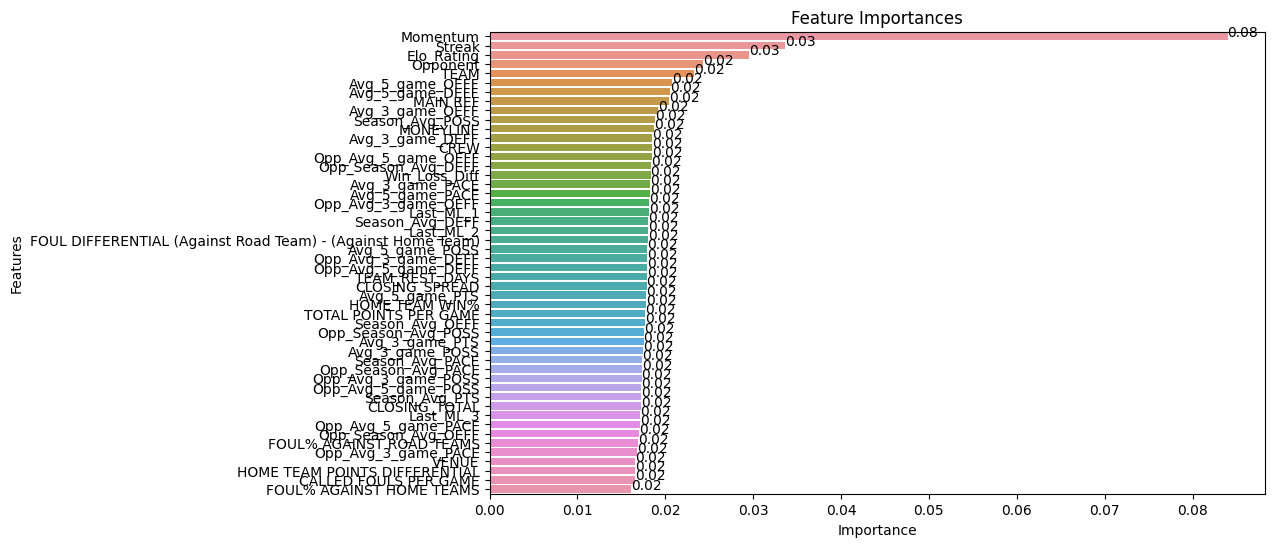

In [30]:
X = df[(df['DATE'] <= pd.to_datetime('2023-12-01'))]
y = X[TARGET]
X = X[TRAIN_COLS]
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# XGBoost Classifier
clf = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1)

#('colsample_bytree', 0.8), ('gamma', 7), ('learning_rate', 0.02), ('max_depth', 5), ('min_child_weight', 10), ('n_estimators', 300), ('reg_alpha', 0.2), ('reg_lambda', 0.3), ('subsample', 1.0)
param_grid = {
    'max_depth': [8],
    'learning_rate': [0.02],
    'n_estimators': [600],
    'gamma': [7],
    'subsample': [1],
    'colsample_bytree': [0.8],
    'min_child_weight': [10],
    'reg_lambda': [0.3],
    'reg_alpha': [0.2]

    # Add other parameters if needed
}

# Grid search with cross-validation
grid_clf = GridSearchCV(clf, param_grid, verbose=3)
grid_clf.fit(X_train, y_train)

# Best hyperparameters and model
print("Best hyperparameters:", grid_clf.best_params_)
best_model = grid_clf.best_estimator_

# Evaluate on test set
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')

# Assuming you have these lists
feature_names = TRAIN_COLS
importances = best_model.feature_importances_

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Optional: Add value labels on each bar
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}')

plt.show()


## Testing

### Helper functions for testing

In [31]:
def american_odds_to_probability(odds):
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = -odds / (-odds + 100)
    return probability

def calculate_profit(odds, size):
    if odds > 0:
        profit = (odds / 100) * size
    else:
        profit = (100 / -(odds + 0.0000001)) * size
    return profit

def kelly_criterion(bankroll, probability, odds, temper=1):
    """
    Calculate the optimal bet size using the Kelly Criterion.

    :param bankroll: Total amount of money you have to bet with.
    :param probability: The probability of the bet winning (from 0 to 1).
    :param odds: The odds being offered on the bet (in decimal format).
    :return: The recommended bet size according to the Kelly Criterion.
    """
    # Convert American odds to decimal if necessary
    if odds > 0:
        odds = (odds / 100) + 1
    elif odds < 0:
        odds = (100 / -odds) + 1

    # Calculate the Kelly bet fraction
    b = odds - 1  # Decimal odds minus 1
    q = 1 - probability  # Probability of losing
    kelly_fraction = (b * probability - q) / b

    # Calculate the recommended bet
    recommended_bet = (temper * kelly_fraction) * bankroll

    return recommended_bet

def combine_parlay_odds(odds_list):
    total_multiplier = 1
    for odds in odds_list:
        if odds > 0:  # Positive odds
            total_multiplier *= (odds / 100) + 1
        else:  # Negative odds
            total_multiplier *= 1 - (100 / (odds + 0.0000001))

    # Calculate parlay odds
    if total_multiplier >= 2:
        parlay_odds = (total_multiplier - 1) * 100
    else:
        parlay_odds = -100 / ((total_multiplier - 1) + 0.00000001)
    return parlay_odds

def get_top_bottom_features_with_scores(pred_contributions, feature_names):
    # Pair feature names with their contributions
    feature_contributions = zip(feature_names, pred_contributions)

    # Sort by the absolute value of contributions but keep the original sign
    sorted_features = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)

    # Get top 5 and bottom 5 features based on absolute value
    top_5_features = sorted_features[:5]
    bottom_5_features = sorted_features[-5:]

    return top_5_features, bottom_5_features

    return round(parlay_odds)
def print_wrapper(func):
    ansi_reset = '\033[0m'
    ansi_black = '\033[90m'
    ansi_red = '\033[91m'
    ansi_green = '\033[92m'
    ansi_yellow = '\033[93m'
    ansi_blue = '\033[94m'
    ansi_pink = '\033[95m'
    ansi_teal = '\033[96m'
    ansi_gray = '\033[97m'
    ansi_warning = '\033[31;1;4m'
    ansi_error = '\033[31;100m'
    def wrapped_func(*args,**kwargs):
        new_args = args + tuple()
        new_kwargs = kwargs.copy()
        for kwarg, kwvalue in kwargs.items(): # Loop through the keyword arguments
            if kwarg == "color":
                if kwvalue == "black":
                    color = ansi_black
                elif kwvalue == "red":
                    color = ansi_red
                elif kwvalue == "green":
                    color = ansi_green
                elif kwvalue == "yellow":
                    color = ansi_yellow
                elif kwvalue == "blue":
                    color = ansi_blue
                elif kwvalue == "pink":
                    color = ansi_pink
                elif kwvalue == "teal":
                    color = ansi_teal
                elif kwvalue == "gray":
                    color = ansi_gray
                elif kwvalue == "warning":
                    color = ansi_warning
                elif kwvalue == "error":
                    color = ansi_error
                new_kwargs = kwargs.copy() # Make a copy of the keyword arguments dict
                del new_kwargs["color"] # Remove color from the keyword arguments dict
        try: # Is the variable color defined?
            color
        except NameError:
            pass
            # no color was specified
        else:
            new_args = ()
            for arg in args:
                new_args += (f"{color}{arg}{ansi_reset}",) # Apply the ANSI escape codes to each non-keyword argument
        return func(*new_args,**new_kwargs)
    return wrapped_func

print = print_wrapper(print) # Apply the wrapper to the print() function

def probability_to_american_odds(probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    if probability == 0.5:
        return 100  # Even odds

    if probability > 0.5:
        return int(-100 * (probability / (1 - probability)))
    else:
        return int(100 * ((1 - probability) / probability))

def odds_to_str(odds):
  if odds <= 0:
    return odds
  else:
    return f'+{odds}'

### Backtesting over games so far this season

2023-10-24 00:00:00...
DAILY STATS
	2 / 2 = 1.0%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%

YEARLY STATS
	2 / 2 = 1.0%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%

2023-10-25 00:00:00...
DAILY STATS
	8 / 12 = 0.67%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%
	4 / 4 = 1.0%

YEARLY STATS
	10 / 14 = 0.71%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%
	4 / 4.00000001 = 1.0%

2023-10-26 00:00:00...
DAILY STATS
	2 / 2 = 1.0%
	0 / 1e-08 = 0.0%
	1 / 1 = 1.0%
	2 / 2 = 1.0%

YEARLY STATS
	12 / 16 = 0.75%
	0 / 1e-08 = 0.0%
	1 / 1.00000001 = 1.0%
	6 / 6.00000001 = 1.0%

2023-10-27 00:00:00...
DAILY STATS
	8 / 11 = 0.73%
	0 / 1e-08 = 0.0%
	1 / 1 = 1.0%
	5 / 7 = 0.71%

YEARLY STATS
	20 / 27 = 0.74%
	0 / 1e-08 = 0.0%
	2 / 2.00000001 = 1.0%
	11 / 13.00000001 = 0.85%

2023-10-28 00:00:00...
DAILY STATS
	5 / 7 = 0.71%
	0 / 1e-08 = 0.0%
	0 / 1e-08 = 0.0%
	1 / 2 = 0.5%

YEARLY STATS
	25 / 34 = 0.74%
	0 / 1e-08 = 0.0%
	2 / 2.00000001 = 1.0%
	12 / 15.00000001 = 0.8%

2023-10-29 00:00:00...
DAILY STATS
	

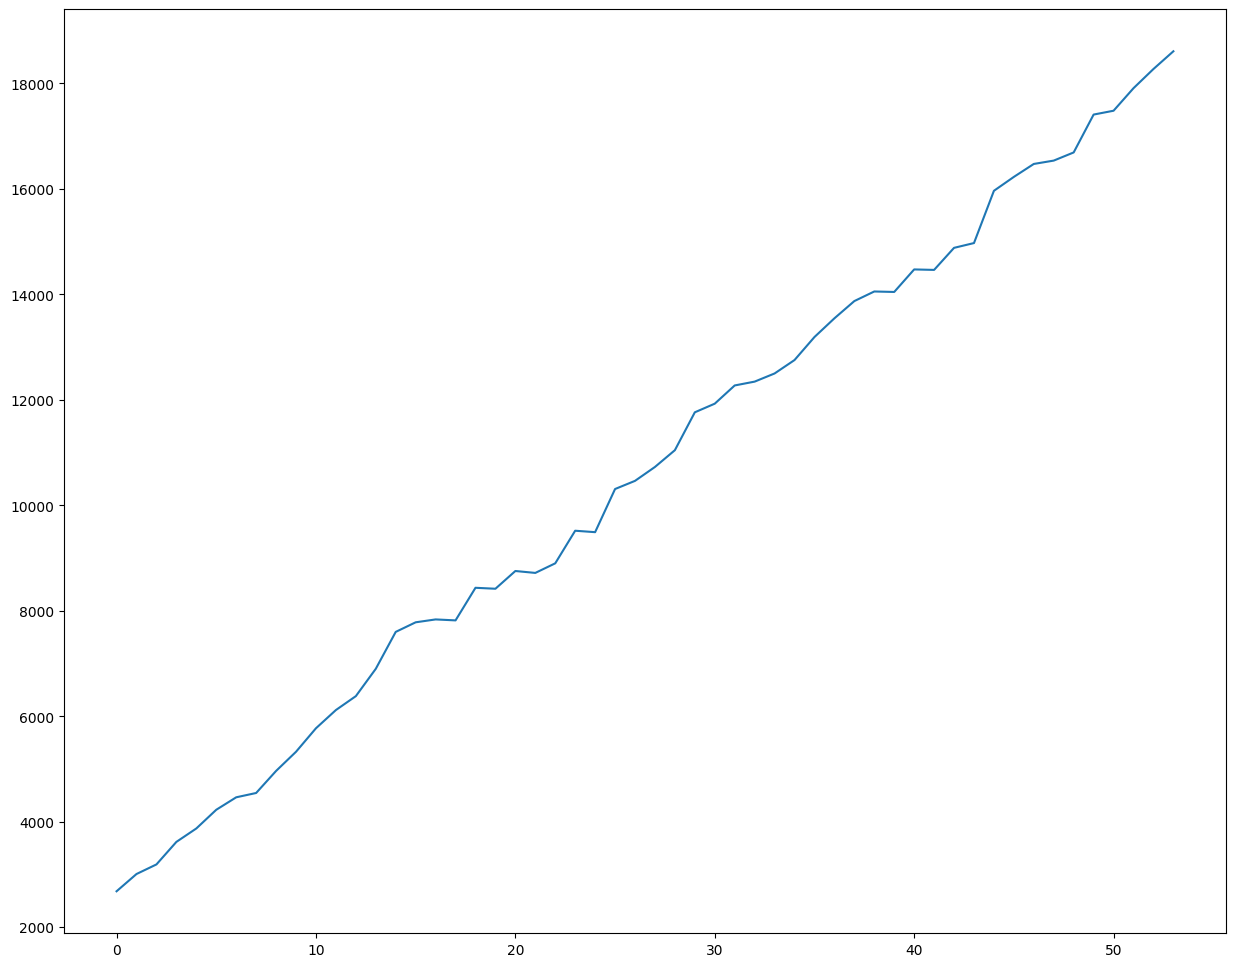

Final Bankroll: 18609.359999999997
Total Profit: 16109.359999999997


In [22]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0

    if hit_all and total > 1:
      print(f'\tBANGGG!!! Hit a {total} leg parlay at +{combine_parlay_odds(all_all_odds)} - pays {round(calculate_profit(combine_parlay_odds(all_all_odds), bankroll*0.1), 2)}')
    if hit_all_all and total > 1:
      print(f'\t HOLY SHIT WE CLEARED A {total} LEG SLATE AT +{combine_parlay_odds(all_all_odds)} PAID {round(calculate_profit(combine_parlay_odds(all_all_odds), 10), 2)}')
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    total_wins, total_bets, total_losses = 0,0,0
    total_90_wins, total_90_bets, total_90_losses = 0,0,0
    total_75_wins, total_75_bets, total_75_losses = 0,0,0
    total_60_wins, total_60_bets, total_60_losses = 0,0,0

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        day_wins, day_bets, day_losses = 0,0,0
        day_90_wins, day_90_bets, day_90_losses = 0,0,0
        day_75_wins, day_75_bets, day_75_losses = 0,0,0
        day_60_wins, day_60_bets, day_60_losses = 0,0,0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            probabilities = model.predict_proba(X)
            predictions = probabilities[:, 1] >= thresh

            #matchups = [(team, prob1, opp, prob2)]
            do_bet = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1] > model.predict_proba(X[X['TEAM'] == opp])[:, 1] for team, opp in zip(X['TEAM'], X['Opponent'])}
            normed_odds = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1]/(model.predict_proba(X[X['TEAM'] == team])[:, 1] + model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0

            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False


            # for all the options today
            for pred, actual, odds, prob, team, opp in zip(predictions, y, day_data[odds_col], probabilities[:, 1], X['TEAM'].values, X['Opponent'].values):

                odds = -110 #if odds == 'even' else int(odds)

                made_a_bet = True
                # get optimal bet size
                bet_size = 100 #round(kelly_criterion(start_bankroll, normed_odds[team][0], odds, 0.5), 2)

                # if we can afford to bet on this
                if (bankroll - bet_size) >= 0:

                    # how much would we win
                    to_win = round(calculate_profit(odds, bet_size), 2)

                    # if this crosses the probability threshold we want to bet on,
                    # and we don't want to bet on the other team:
                    if do_bet[team] and (bet_size > 0):
                        day_bets += 1
                        bankroll -= bet_size
                        num_bets += 1
                        if actual:
                            day_wins += 1
                            #print(f'\tWon {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='green')
                            day_profit += (to_win + bet_size)
                            wins += 1
                        else:
                            day_losses += 1
                            #print(f'\tLost {bet_size} trying to win {to_win}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='red')
                            losses += actual != pred
                            hit_all = False

                    if normed_odds[team] >= 0.9:
                      day_90_bets += 1
                      if actual:
                        day_90_wins += 1
                      else:
                         day_90_losses += 1

                    if normed_odds[team] >= 0.75:
                      day_75_bets += 1
                      if actual:
                        day_75_wins += 1
                      else:
                         day_75_losses += 1

                    if normed_odds[team] >= 0.6:
                      day_60_bets += 1
                      if actual:
                        day_60_wins += 1
                      else:
                         day_60_losses += 1


            total_wins += day_wins
            total_bets += day_bets
            total_losses += day_losses

            total_90_wins += day_90_wins
            total_90_bets += day_90_bets
            total_90_losses += day_90_losses

            total_75_wins += day_75_wins
            total_75_bets += day_75_bets
            total_75_losses += day_75_losses

            total_60_wins += day_60_wins
            total_60_bets += day_60_bets
            total_60_losses += day_60_losses

            day_bets = day_bets if day_bets > 0 else 0.00000001
            day_90_bets = day_90_bets if day_90_bets > 0 else 0.00000001
            day_75_bets = day_75_bets if day_75_bets > 0 else 0.00000001
            day_60_bets = day_60_bets if day_60_bets > 0 else 0.00000001

            total_bets = total_bets if total_bets > 0 else 0.00000001
            total_90_bets = total_90_bets if total_90_bets > 0 else 0.00000001
            total_75_bets = total_75_bets if total_75_bets > 0 else 0.00000001
            total_60_bets = total_60_bets if total_60_bets > 0 else 0.00000001

            print('DAILY STATS')
            print(f'\t{day_wins} / {day_bets} = {round(day_wins / day_bets,2)}%')
            print(f'\t{day_90_wins} / {day_90_bets} = {round(day_90_wins / day_90_bets,2)}%')
            print(f'\t{day_75_wins} / {day_75_bets} = {round(day_75_wins / day_75_bets,2)}%')
            print(f'\t{day_60_wins} / {day_60_bets} = {round(day_60_wins / day_60_bets,2)}%')

            print('\nYEARLY STATS')
            print(f'\t{total_wins} / {total_bets} = {round(total_wins / total_bets,2)}%')
            print(f'\t{total_90_wins} / {total_90_bets} = {round(total_90_wins / total_90_bets,2)}%')
            print(f'\t{total_75_wins} / {total_75_bets} = {round(total_75_wins / total_75_bets,2)}%')
            print(f'\t{total_60_wins} / {total_60_bets} = {round(total_60_wins / total_60_bets,2)}%\n')


            bankroll += day_profit
            #print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=best_model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='MONEYLINE',
    start_date='2023-10-24',
    end_date='2023-12-21',
    initial_bankroll=2500,
    bet_size=2
)
plt.subplots(figsize=(15,12))
plt.plot(bet_results)
plt.show()
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


2023-10-24 00:00:00...
beat Golden State at 2.5 - our model pinned it at 0.23000000417232513
DAILY STATS
	1 / 0 = 1.0%

YEARLY STATS
	1 / 0 = 1.0%
2023-10-25 00:00:00...
beat Atlanta at 4.0 - our model pinned it at -4.869999885559082
beat Washington at -5.0 - our model pinned it at -7.800000190734863
beat Houston at -4.5 - our model pinned it at -9.199999809265137
beat Miami at 9.5 - our model pinned it at 6.110000133514404
beat Memphis at 1.0 - our model pinned it at 0.05000000074505806
beat Utah at -1.5 - our model pinned it at -3.5
beat Chicago at 2.5 - our model pinned it at -7.650000095367432
DAILY STATS
	7 / 0 = 1.0%

YEARLY STATS
	8 / 0 = 1.0%
2023-10-26 00:00:00...
beat Milwaukee at 6.0 - our model pinned it at 2.740000009536743
DAILY STATS
	1 / 0 = 1.0%

YEARLY STATS
	9 / 0 = 1.0%
2023-10-27 00:00:00...
beat Charlotte at 4.5 - our model pinned it at -7.659999847412109
beat Cleveland at 2.0 - our model pinned it at -4.010000228881836
beat Chicago at 2.5 - our model pinned it at

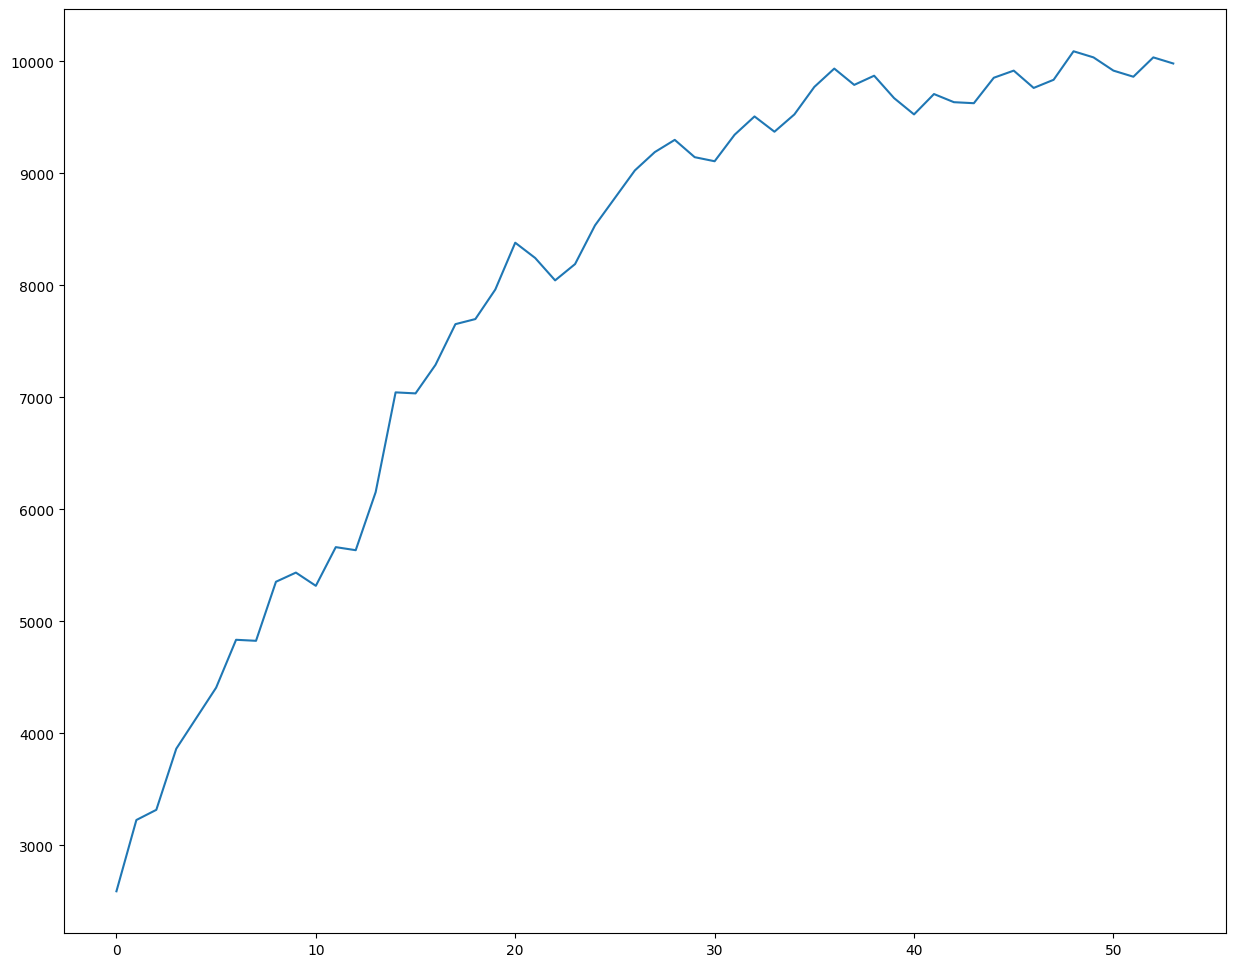

Final Bankroll: 9982.049999999992
Total Profit: 7482.049999999992


In [16]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0

    if hit_all and total > 1:
      print(f'\tBANGGG!!! Hit a {total} leg parlay at +{combine_parlay_odds(all_all_odds)} - pays {round(calculate_profit(combine_parlay_odds(all_all_odds), bankroll*0.1), 2)}')
    if hit_all_all and total > 1:
      print(f'\t HOLY SHIT WE CLEARED A {total} LEG SLATE AT +{combine_parlay_odds(all_all_odds)} PAID {round(calculate_profit(combine_parlay_odds(all_all_odds), 10), 2)}')
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    total_wins, total_bets, total_losses = 0,0,0
    total_90_wins, total_90_bets, total_90_losses = 0,0,0
    total_75_wins, total_75_bets, total_75_losses = 0,0,0
    total_60_wins, total_60_bets, total_60_losses = 0,0,0

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        day_wins, day_bets, day_losses = 0,0,0
        day_90_wins, day_90_bets, day_90_losses = 0,0,0
        day_75_wins, day_75_bets, day_75_losses = 0,0,0
        day_60_wins, day_60_bets, day_60_losses = 0,0,0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            predictions = model.predict(X)
            #predictions = probabilities[:, 1] >= thresh

            #matchups = [(team, prob1, opp, prob2)]
            do_bet = {team: model.predict(X[X['TEAM'] == team])[0] < (X[X['TEAM'] == team])['CLOSING_SPREAD'].values[0] for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            #normed_odds = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1]/(model.predict_proba(X[X['TEAM'] == team])[:, 1] + model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0

            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False

            results = {team: (day_data[day_data['TEAM'] == team])['CLOSING_SPREAD'].values[0] + (day_data[day_data['TEAM'] == team])['PTS'].values[0] > (day_data[day_data['TEAM'] == opp])['PTS'].values[0] for team, opp in zip(X['TEAM'], X['Opponent'])}


            # for all the options today
            for pred, odds, team, opp in zip(predictions, day_data[odds_col], X['TEAM'].values, X['Opponent'].values):
                actual = results[team]
                odds = -110 #if odds == 'even' else int(odds)

                made_a_bet = True
                # get optimal bet size
                bet_size = 100 #round(kelly_criterion(start_bankroll, normed_odds[team][0], odds, 0.5), 2)

                # if we can afford to bet on this
                if (bankroll - bet_size) >= 0:

                    # how much would we win
                    to_win = round(calculate_profit(odds, bet_size), 2)

                    # if this crosses the probability threshold we want to bet on,
                    # and we don't want to bet on the other team:
                    if do_bet[team] and (bet_size > 0):
                        day_bets += 1
                        bankroll -= bet_size
                        num_bets += 1
                        if actual:
                            day_wins += 1
                            print(f"beat {opp} at {X[X['TEAM'] == team]['CLOSING_SPREAD'].values[0]} - our model pinned it at {round(pred, 2)}", color='green')
                            day_profit += (to_win + bet_size)
                            wins += 1
                        else:
                            day_losses += 1
                            print(f"\tLost {opp} at {X[X['TEAM'] == team]['CLOSING_SPREAD'].values[0]} - our model pinned it at {pred}", color='red')
                            losses += actual != pred
                            hit_all = False

                    # if normed_odds[team] >= 0.9:
                    #   day_90_bets += 1
                    #   if actual:
                    #     day_90_wins += 1
                    #   else:
                    #      day_90_losses += 1

                    # if normed_odds[team] >= 0.75:
                    #   day_75_bets += 1
                    #   if actual:
                    #     day_75_wins += 1
                    #   else:
                    #      day_75_losses += 1

                    # if normed_odds[team] >= 0.6:
                    #   day_60_bets += 1
                    #   if actual:
                    #     day_60_wins += 1
                    #   else:
                    #      day_60_losses += 1


            total_wins += day_wins
            total_bets += day_bets
            total_losses += day_losses

            # total_90_wins += day_90_wins
            # total_90_bets += day_90_bets
            # total_90_losses += day_90_losses

            # total_75_wins += day_75_wins
            # total_75_bets += day_75_bets
            # total_75_losses += day_75_losses

            # total_60_wins += day_60_wins
            # total_60_bets += day_60_bets
            # total_60_losses += day_60_losses

            # day_bets = day_bets if day_bets > 0 else 0.00000001
            # day_90_bets = day_90_bets if day_90_bets > 0 else 0.00000001
            # day_75_bets = day_75_bets if day_75_bets > 0 else 0.00000001
            # day_60_bets = day_60_bets if day_60_bets > 0 else 0.00000001

            # total_bets = total_bets if total_bets > 0 else 0.00000001
            # total_90_bets = total_90_bets if total_90_bets > 0 else 0.00000001
            # total_75_bets = total_75_bets if total_75_bets > 0 else 0.00000001
            # total_60_bets = total_60_bets if total_60_bets > 0 else 0.00000001

            print('DAILY STATS')
            print(f'\t{day_wins} / {day_losses} = {round(day_wins / day_bets,2)}%')
            # print(f'\t{day_90_wins} / {day_90_bets} = {round(day_90_wins / day_90_bets,2)}%')
            # print(f'\t{day_75_wins} / {day_75_bets} = {round(day_75_wins / day_75_bets,2)}%')
            # print(f'\t{day_60_wins} / {day_60_bets} = {round(day_60_wins / day_60_bets,2)}%')

            print('\nYEARLY STATS')
            print(f'\t{total_wins} / {total_losses} = {round(total_wins / total_bets,2)}%')
            # print(f'\t{total_90_wins} / {total_90_bets} = {round(total_90_wins / total_90_bets,2)}%')
            # print(f'\t{total_75_wins} / {total_75_bets} = {round(total_75_wins / total_75_bets,2)}%')
            # print(f'\t{total_60_wins} / {total_60_bets} = {round(total_60_wins / total_60_bets,2)}%\n')


            bankroll += day_profit
            #print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=best_model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='CLOSING_SPREAD',
    start_date='2023-10-24',
    end_date='2023-12-20',
    initial_bankroll=2500,
    bet_size=2
)
plt.subplots(figsize=(15,12))
plt.plot(bet_results)
plt.show()
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


## Today

### Get data

In [42]:
pre_tdf = df[(df['Season'] == 2024)]
raw_tdf = pd.read_excel(TODAY_FILE)
raw_tdf.columns = t_cleaned_cols

### Build the dataframe

In [43]:
tdf = raw_tdf
tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf = tdf.sort_values('DATE')
tdf['Season'] = raw_tdf['BIGDATABALL_DATASET'].map(SEASON_MAP)

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    if group.iloc[0]['PTS'] > group.iloc[1]['PTS']:
        group['Result'] = [1, 0]
    else:
        group['Result'] = [0, 1]

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
tdf['Avg_3_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

tdf['Avg_3_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

tdf['Avg_3_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

tdf['Avg_3_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

tdf['Avg_3_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')


# Apply the function to each game group
tdf = tdf.groupby('GAME-ID').apply(assign_results)
# Reset index if needed
tdf.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
tdf['Prev_Result'] = tdf.groupby(['TEAM', 'Season'])['Result'].shift()

# Step 3: Win/Loss Streak
def calculate_streak(group):
    streak = group['Prev_Result'].diff().ne(0).cumsum()
    group['Streak'] = streak.groupby(streak).cumcount()
    group['Streak'] *= group['Prev_Result'].map({1: 1, 0: -1})
    return group

tdf = tdf.groupby(['TEAM', 'Season']).apply(calculate_streak)

# Step 4: Last 3 Games Moneylines
tdf['Last_ML_1'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(1)
tdf['Last_ML_2'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(2)
tdf['Last_ML_3'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(3)

# Step 5: Current Number of Wins - Losses
tdf['Wins'] = tdf.groupby(['TEAM'])['Result'].cumsum()
tdf['Losses'] = tdf.groupby(['TEAM'])['Result'].transform('count') - tdf['Wins']
tdf['Win_Loss_Diff'] = tdf['Wins'] - tdf['Losses']

# Step 6: Current Opponent
tdf['Opponent'] = tdf.groupby('GAME-ID')['TEAM'].shift(-1).fillna(tdf.groupby('GAME-ID')['TEAM'].shift())

# Clean up and remove the temporary 'Prev_Result' column
tdf.drop('Prev_Result', axis=1, inplace=True)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)
refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023])
tdf = tdf.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')
tdf = tdf.sort_values('DATE')
#tdf[['MONEYLINE', 'DATE']].head(10)

### Process dataset and get predictions

In [44]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
t_teams = list(TODAY_MAP.keys())

# Sort df2 by 'name' and 'DATE' in descending  (pre_tdf is the preprocessed
# dataframe with the learned ELO and momentup columns)
temp = pre_tdf.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])

# Drop duplicates, keep the first (latest) entry for each 'name'
temp = temp.drop_duplicates(subset='TEAM')

# Merge df1 with the processed df2
temp = pd.merge(tdf, temp[['TEAM', 'Elo_Rating', 'Momentum']], on='TEAM', how='left', suffixes=('_x', '_y'))

# look at the latest
temp = temp.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])
temp = temp.drop_duplicates(subset='TEAM')[t_train_cols]

temp = temp[temp['TEAM'].isin(t_teams)]
temp.columns = train_cols_final

X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True).replace('BLANK_STRING', '', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# make predictions
probs = best_model.predict_proba(X)
odds = X['MONEYLINE'].values
booster = best_model.get_booster()
normed_odds = {team: best_model.predict_proba(X[X['TEAM'] == team])[:, 1]/(best_model.predict_proba(X[X['TEAM'] == team])[:, 1] + best_model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

pred_contribs = booster.predict(DMatrix(X, enable_categorical=True), pred_contribs=True)


i = 0
for team, win, prob, opp, contribs, elo, mom in zip(X['TEAM'].values, best_model.predict(X), best_model.predict_proba(X)[:, 1], X['Opponent'].values, pred_contribs[:, :-1], X['Elo_Rating'].values, X['Momentum'].values):
  opp_i = np.where(X['TEAM'] == opp)[0][0]
  named_contribs = sorted(zip(TRAIN_COLS, pred_contribs[i, :-1]), key = lambda t: t[1])
  opp_contribs = sorted(zip(TRAIN_COLS, pred_contribs[opp_i, :-1]), key = lambda t: t[1])
  i += 1
  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  our_line = probability_to_american_odds(normed_odds[team][0])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp][0])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team][0], o, temper=0.25)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if (bet >= 0) and do_bet[team]:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team][0]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab} {named_contribs[-1]} </h4>
                      <h4> - {tab} {named_contribs[-2]} </h4>
                      <h4> - {tab} {named_contribs[-3]} </h4>
                      <h4> - {tab} {named_contribs[-4]} </h4>
                      <h4> - {tab} {named_contribs[-5]} </h4>
                      <h3> Worst Features: </h3>
                      <h4> - {tab} {named_contribs[0]} </h4>
                      <h4> - {tab} {named_contribs[1]} </h4>
                      <h4> - {tab} {named_contribs[2]} </h4>
                      <h4> - {tab} {named_contribs[3]} </h4>
                      <h4> - {tab} {named_contribs[4]} </h4>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp][0]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab} {opp_contribs[-1]} </h4>
                      <h4> - {tab} {opp_contribs[-2]} </h4>
                      <h4> - {tab} {opp_contribs[-3]} </h4>
                      <h4> - {tab} {opp_contribs[-4]} </h4>
                      <h4> - {tab} {opp_contribs[-5]} </h4>
                      <h3> Worst Features: </h3>
                      <h4> - {tab} {opp_contribs[0]} </h4>
                      <h4> - {tab} {opp_contribs[1]} </h4>
                      <h4> - {tab} {opp_contribs[2]} </h4>
                      <h4> - {tab} {opp_contribs[3]} </h4>
                      <h4> - {tab} {opp_contribs[4]} </h4>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team] and (bet < 0):
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team][0]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab} {named_contribs[-1]} </h4>
                      <h4> - {tab} {named_contribs[-2]} </h4>
                      <h4> - {tab} {named_contribs[-3]} </h4>
                      <h4> - {tab} {named_contribs[-4]} </h4>
                      <h4> - {tab} {named_contribs[-5]} </h4>
                      <h3> Worst Features: </h3>
                      <h4> - {tab} {named_contribs[0]} </h4>
                      <h4> - {tab} {named_contribs[1]} </h4>
                      <h4> - {tab} {named_contribs[2]} </h4>
                      <h4> - {tab} {named_contribs[3]} </h4>
                      <h4> - {tab} {named_contribs[4]} </h4>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp][0]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                      <h3> Best Features: </h3>
                      <h4> - {tab} {opp_contribs[-1]} </h4>
                      <h4> - {tab} {opp_contribs[-2]} </h4>
                      <h4> - {tab} {opp_contribs[-3]} </h4>
                      <h4> - {tab} {opp_contribs[-4]} </h4>
                      <h4> - {tab} {opp_contribs[-5]} </h4>
                      <h3> Worst Features: </h3>
                      <h4> - {tab} {opp_contribs[0]} </h4>
                      <h4> - {tab} {opp_contribs[1]} </h4>
                      <h4> - {tab} {opp_contribs[2]} </h4>
                      <h4> - {tab} {opp_contribs[3]} </h4>
                      <h4> - {tab} {opp_contribs[4]} </h4>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


<IPython.core.display.Javascript object>

___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


In [ ]:
X[['TEAM', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL']]

,TEAM,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL
617,Atlanta,+125,+2.5,242.5
624,Boston,-425,-9.5,224.5
626,Brooklyn,+145,+4.5,236.5
622,Charlotte,+140,+4.5,221.5
631,Chicago,+225,+7.5,215.5
640,Cleveland,+340,+9.5,224.5
637,Dallas,+110,+1.5,BLANK_STRING
636,Denver,-275,-7.5,215.5
619,Detroit,+230,+7.5,247.5
627,Golden State,+125,+3.5,232.5


#### Optional Visualizations

In [ ]:
num_features = len(TRAIN_COLS)
num_inferences = len(pred_contribs)

# Creating subplots
fig, axes = plt.subplots(num_inferences, 1, figsize=(15, 5 * num_inferences))
if num_inferences == 1:
    axes = [axes]

# Plotting each inference
for i,(_, row) in enumerate(X.iterrows()):
    ax = axes[i]
    y_pos = np.arange(num_features + 1)
    contributions = pred_contribs[i]

    ax.barh(y_pos, contributions, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(TRAIN_COLS + ['BIAS'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Contributions')
    ax.set_title(f'{row["TEAM"]}')

plt.tight_layout()
plt.show()

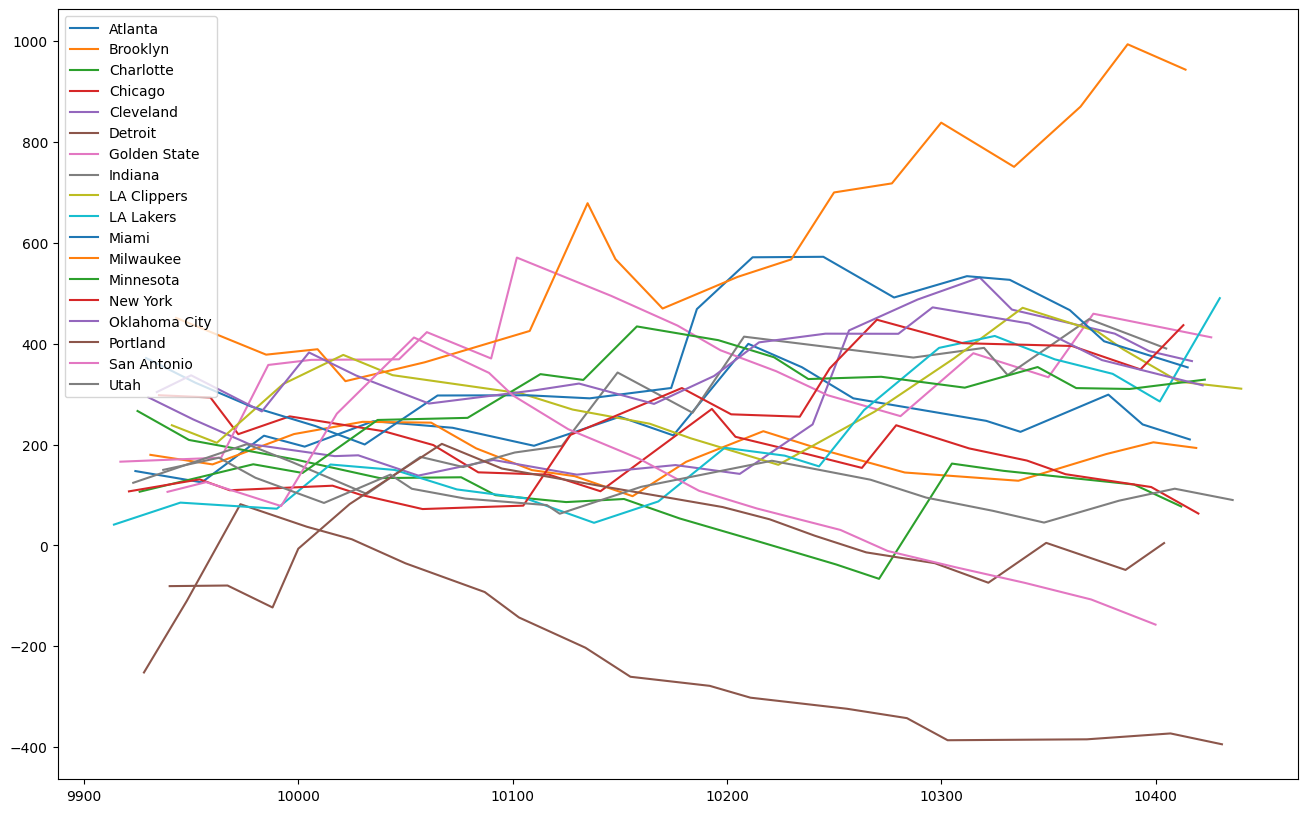

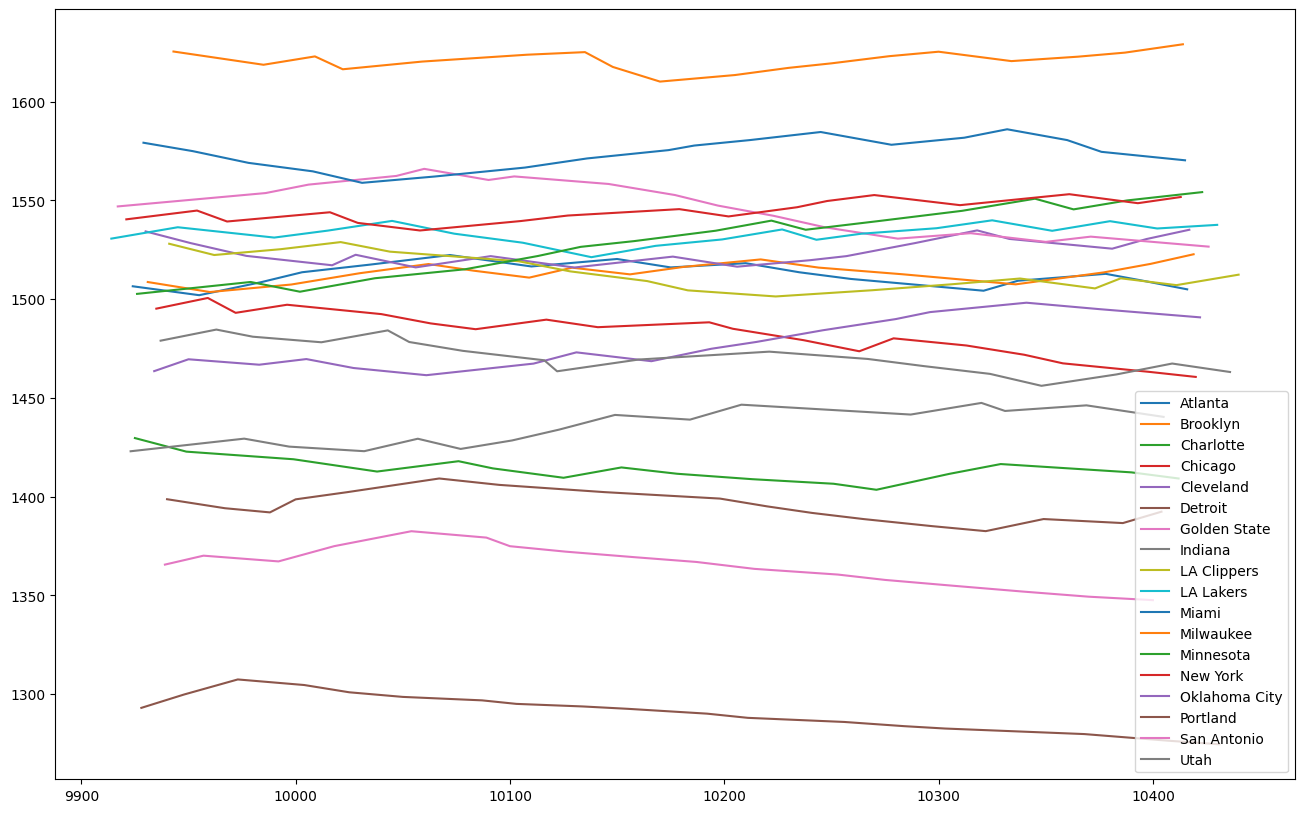

In [ ]:
plt.subplots(figsize=(16, 10))
pre_tdf[pre_tdf['TEAM'].isin(t_teams)].groupby('TEAM')['Momentum'].plot()
plt.legend()
plt.show()

plt.subplots(figsize=(16, 10))
pre_tdf[pre_tdf['TEAM'].isin(t_teams)].groupby('TEAM')['Elo_Rating'].plot()
plt.legend()
plt.show()

In [25]:
df.head(100)['TEAM'].value_counts()['Toronto']

4



### Bootstrapping for confidence intervals

In [49]:
n_bootstrap_samples = 100  # Number of bootstrap samples
bootstrap_models = []
weights_dicts = []

# Generate bootstrap samples and train a model on each
for _ in range(n_bootstrap_samples):

    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=int(len(X_train)), replace=True)
    weights_dicts.append(X_train_sample['TEAM'].value_counts())
    model = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1, kwargs={'colsample_bytree': 0.8, 'gamma': 7, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 300, 'reg_alpha': 0.2, 'reg_lambda': 0.3, 'subsample': 1})
    model.fit(X_train_sample, y_train_sample)
    bootstrap_models.append(model)

# try:
#   X = X.drop('prob', axis=1)
# except:
#   pass
# # Make predictions on the test set with each model
# predictions = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])

# # Calculate the mean and 95% confidence interval for each prediction
# prediction_means = predictions.mean(axis=0)
# confidence_lower = np.percentile(predictions, 2.5, axis=0)
# confidence_upper = np.percentile(predictions, 97.5, axis=0)

# prediction_long_df = pd.DataFrame(predictions)

# # Create the boxplot
# plt.figure(figsize=(14, 10))
# sns.boxplot(data=prediction_long_df, palette="Set2", whis=[2.5, 97.5])

# # Add mean and confidence interval lines for each test sample
# for i in range(prediction_means.shape[0]):
#     plt.plot([i, i], [confidence_lower[i], confidence_upper[i]], color='gray', lw=2)
#     plt.scatter([i], [prediction_means[i]], color='green', marker='o', label='Our Prediction')
#     plt.scatter(range(len(X)), [american_odds_to_probability(x) for x in X['MONEYLINE'].values], color='red', label='Vegas')

# plt.title('Bootstrap Predictions with Confidence Intervals')
# plt.xlabel('Slate')
# plt.xticks(range(prediction_means.shape[0]), X['TEAM'].values)
# plt.ylabel('Predicted Probability')
# #plt.legend()

# # Customize the plot to make it more suitable for a business presentation
# plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
# plt.grid(True)  # Add grid for easier reading

# plt.tight_layout()
# plt.show()

In [33]:
import pickle

with open('spread_weights.pkl', 'wb') as file:
    pickle.dump(weights_dicts, file)

In [13]:
weights_dicts[1]

Boston           319
LA Lakers        293
Washington       280
LA Clippers      279
Miami            279
Phoenix          274
Golden State     273
Brooklyn         273
Milwaukee        271
Oklahoma City    270
Memphis          268
Dallas           267
Philadelphia     260
New York         258
Cleveland        257
Utah             248
Sacramento       245
Portland         245
New Orleans      241
Minnesota        240
Atlanta          236
Houston          234
Denver           228
San Antonio      226
Toronto          225
Chicago          220
Charlotte        216
Indiana          211
Detroit          208
Orlando          195
Name: TEAM, dtype: int64

In [34]:
X_train['TEAM'].value_counts()

LA Lakers        283
Boston           282
Milwaukee        281
Phoenix          278
Miami            276
Dallas           272
Denver           272
LA Clippers      261
Brooklyn         259
Philadelphia     259
Washington       257
Utah             254
Houston          254
New Orleans      252
New York         246
Cleveland        246
Oklahoma City    244
Toronto          244
Minnesota        243
Indiana          242
Atlanta          240
Golden State     239
Memphis          238
San Antonio      236
Portland         234
Orlando          232
Chicago          232
Sacramento       232
Detroit          227
Charlotte        224
Name: TEAM, dtype: int64

In [15]:
w = []
for weights in weights_dicts:
  w.append((weights/X_train['TEAM'].value_counts()).pow(10)['Atlanta'])

w = np.array(w)
w = w/w.sum()
w

array([0.00310967, 0.00241925, 0.00241925, 0.00263227, 0.00381532,
       0.00241925, 0.0035174 , 0.00212873, 0.00203911, 0.00298354,
       0.00324059, 0.00222187, 0.00131247, 0.00381532, 0.00298354,
       0.00714691, 0.00929391, 0.00800529, 0.00397263, 0.00156908,
       0.00770938, 0.00714691, 0.00324059, 0.00448021, 0.00637227,
       0.00524762, 0.00448021, 0.00119891, 0.00324059, 0.00274498,
       0.0017136 , 0.00485027, 0.0019529 , 0.00524762, 0.00186999,
       0.00504543, 0.00222187, 0.00286202, 0.00366363, 0.00545708,
       0.00286202, 0.00430488, 0.00163991, 0.01487392, 0.00800529,
       0.0133703 , 0.00862798, 0.00413575, 0.00800529, 0.00397263,
       0.00286202, 0.00466194, 0.00381532, 0.00337644, 0.00131247,
       0.00252374, 0.00929391, 0.00252374, 0.00337644, 0.00366363,
       0.0017136 , 0.00397263, 0.01157849, 0.00163991, 0.00862798,
       0.00241925, 0.00366363, 0.00831139, 0.0035174 , 0.00286202,
       0.00274498, 0.00895537, 0.00241925, 0.00252374, 0.00742

### Bootstrapped backtesting...

2023-12-10 00:00:00...
2023-12-11 00:00:00...
[0.64013575 0.61832459 0.04151519 0.06959248 0.46623466 0.78961334
 0.03329965 0.80562833 0.71306053 0.88762215 0.95571161 0.67147739
 0.61862479 0.00923419 0.71157506 0.08474032 0.68722113 0.02640743
 0.93831443 0.72664409 0.15560204 0.17410913 0.03484438 0.67390345
 0.17107143 0.8818216 ]
	Won 227.27 betting 250
		Philadelphia to beat Washington at -110 - our model pinned it at -177
	Lost 250 trying to win 227.27
		Orlando to beat Cleveland at -110 - our model pinned it at 114
	Won 227.27 betting 250
		Miami to beat Charlotte at -110 - our model pinned it at -414
	Won 227.27 betting 250
		New York to beat Toronto at -110 - our model pinned it at -789
	Won 227.27 betting 250
		Denver to beat Atlanta at -110 - our model pinned it at -2157
	Won 227.27 betting 250
		Indiana to beat Detroit at -110 - our model pinned it at -204
	Won 227.27 betting 250
		Memphis to beat Dallas at -110 - our model pinned it at -246
	Won 227.27 betting 250
		Okla

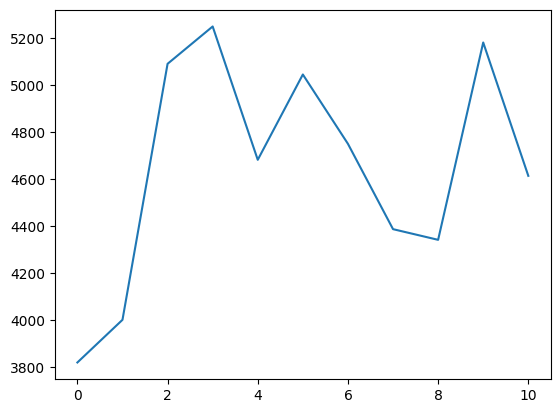

In [50]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0

    if hit_all and total > 1:
      print(f'\tBANGGG!!! Hit a {total} leg parlay at +{combine_parlay_odds(all_odds)} - pays {round(calculate_profit(combine_parlay_odds(all_odds), 10), 2)}')
    if hit_all_all and total > 1:
      print(f'\t HOLY SHIT WE CLEARED A {total} LEG SLATE AT +{combine_parlay_odds(all_all_odds)} PAID {round(calculate_profit(combine_parlay_odds(all_all_odds), 150), 2)}')
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def weight_probabilities(X, raw_probs, weights_arr):
    weighted_probs = []
    for i,team in enumerate(X['TEAM']):
        w = []
        for weights in weights_arr:
            w.append((weights/X_train['TEAM'].value_counts()).pow(10)[team])
        w = np.array(w)
        w = w/w.sum()
        weighted_probs.append(w*raw_probs[:, i])
    return np.array(weighted_probs)


def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            #probabilities = model.predict_proba(X)
            preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])
            #print(preds)
            preds = weight_probabilities(X, preds, weights_dicts)
            #print(preds)
            # Calculate the mean and 95% confidence interval for each prediction
            probabilities = preds.sum(axis=1)
            print(probabilities)
            predictions = np.array([x > 0.5 for x in probabilities])

            #matchups = [(team, prob1, opp, prob2)]
            do_bet = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1] > model.predict_proba(X[X['TEAM'] == opp])[:, 1] for team, opp in zip(X['TEAM'], X['Opponent'])}
            normed_odds = {team: model.predict_proba(X[X['TEAM'] == team])[:, 1]/(model.predict_proba(X[X['TEAM'] == team])[:, 1] + model.predict_proba(X[X['TEAM'] == opp])[:, 1]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0
            all_odds = []
            all_all_odds = []
            hit_all = True
            hit_all_all = True

            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False
            made_a_bet = 0
            # for all the options today
            for pred, actual, odds, prob, team, opp in zip(predictions, y, day_data[odds_col], probabilities, X['TEAM'].values, X['Opponent'].values):

                # only look at predicted winners
                if do_bet[team]:

                    # get odds as integer
                    odds = -110 #if odds == 'even' else int(odds)
                    # get optimal bet size
                    bet_size = 250 #round(kelly_criterion(start_bankroll, normed_odds[team][0], odds, 0.5), 2)

                    # if we can afford to bet on this
                    if (bankroll - bet_size) >= 0:

                        # how much would we win
                        to_win = round(calculate_profit(odds, bet_size), 2)

                        # if this crosses the probability threshold we want to bet on,
                        # and we don't want to bet on the other team:
                        if do_bet[team] and (bet_size > 0):
                            bankroll -= bet_size
                            num_bets += 1
                            if actual:
                                print(f'\tWon {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='green')
                                day_profit += (to_win + bet_size)
                                wins += 1
                            else:
                                print(f'\tLost {bet_size} trying to win {to_win}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='red')
                                losses += actual != pred
                                hit_all = False
                            all_odds.append(odds)
                        #if (prob > thresh) and not do_bet[team] and (bet_size > 0) and actual:
                        #      print(f'\tWanted to win {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(prob))}', color='warning')

                if [normed_odds[team]][0] > 0.7:
                  made_a_bet += 1
                  all_all_odds.append(int(odds))
                  if not actual:
                    hit_all_all = False



            # if made_a_bet > 1:
            #   if hit_all_all:
            #     total_odds = combine_parlay_odds(all_all_odds)
            #     bankroll += round(calculate_profit(combine_parlay_odds(all_all_odds), 150), 2)
            #   else:
            #     bankroll -= 150

            bankroll += day_profit
            print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll, hit_all, all_odds, hit_all_all, all_all_odds)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=df,
    model=best_model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='MONEYLINE',
    start_date='2023-12-10',
    end_date='2023-12-22',
    initial_bankroll=2500,
    bet_size=2
)
plt.plot(bet_results)
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


In [51]:

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
t_teams = list(TODAY_MAP.keys())

# Sort df2 by 'name' and 'DATE' in descending  (pre_tdf is the preprocessed
# dataframe with the learned ELO and momentup columns)
temp = pre_tdf.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])

# Drop duplicates, keep the first (latest) entry for each 'name'
temp = temp.drop_duplicates(subset='TEAM')

# Merge df1 with the processed df2
temp = pd.merge(tdf, temp[['TEAM', 'Elo_Rating', 'Momentum']], on='TEAM', how='left', suffixes=('_x', '_y'))

# look at the latest
temp = temp.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])
temp = temp.drop_duplicates(subset='TEAM')[t_train_cols]

temp = temp[temp['TEAM'].isin(t_teams)]
temp.columns = train_cols_final

X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True).replace('--', '-100', regex=True).replace('BLANK_STRING', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# make predictions
probs = best_model.predict_proba(X)

preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])
#print(preds)
preds = weight_probabilities(X, preds, weights_dicts)
#print(preds)
# Calculate the mean and 95% confidence interval for each prediction
probabilities = preds.sum(axis=1)
print(probabilities)
predictions = np.array([x > 0.5 for x in probabilities])

X['prob'] = probabilities

odds = X['MONEYLINE'].values
booster = best_model.get_booster()
#display(X[X['TEAM'] == team])
do_bet = {team: X[X['TEAM'] == team]['prob'].values[0] > X[X['TEAM'] == opp]['prob'].values[0] for team, opp in zip(X['TEAM'], X['Opponent'])}
normed_odds = {team: X[X['TEAM'] == team]['prob'].values[0]/(X[X['TEAM'] == team]['prob'].values[0] + X[X['TEAM'] == opp]['prob'].values[0]) for team, opp in zip(X['TEAM'], X['Opponent'])}
#print(normed_odds)
#pred_contribs = booster.predict(DMatrix(X, enable_categorical=True), pred_contribs=True)


for team, win, prob, opp, elo, mom in zip(X['TEAM'].values, preds, probabilities, X['Opponent'].values, X['Elo_Rating'].values, X['Momentum'].values):

  # get the most important features
  #helpers = np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[-3:]]
  #detractions = (np.array(TRAIN_COLS)[np.argpartition(contribs, -3)[:3]])

  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  #print(normed_odds[team])
  our_line = probability_to_american_odds(normed_odds[team])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team], o, temper=0.2)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if (bet >= 0) and do_bet[team]:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team]:
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{round(normed_odds[team]*100, 2)}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{round(normed_odds[opp]*100, 2)}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


<IPython.core.display.Javascript object>

KeyError: ignored

In [70]:
X.drop(['Opp_Avg_3_game_DEFF',	'Opp_Avg_5_game_DEFF', 'Opp_Avg_3_game_POSS',	'Opp_Avg_5_game_POSS',	'Opp_Season_Avg_POSS',	'Avg_3_game_DEFF',	'Avg_5_game_DEFF',	'Season_Avg_DEFF',	'Avg_3_game_OEFF',	'Avg_5_game_OEFF',	'Season_Avg_OEFF',	'Opp_Season_Avg_DEFF',	'Opp_Avg_3_game_OEFF',	'Opp_Avg_5_game_OEFF',	'Opp_Season_Avg_OEFF',	'Opp_Avg_3_game_PACE',	'Opp_Avg_5_game_PACE',	'Opp_Season_Avg_PACE'], axis=1)

,CREW,Avg_3_game_PACE,Avg_5_game_PACE,Season_Avg_PACE,Avg_3_game_POSS,Avg_5_game_POSS,Season_Avg_POSS,CLOSING_SPREAD,CLOSING_TOTAL,MONEYLINE,...,TOTAL POINTS PER GAME,CALLED FOULS PER GAME,FOUL% AGAINST ROAD TEAMS,FOUL% AGAINST HOME TEAMS,FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team),Elo_Rating,Momentum,MAIN REF,TEAM_REST_DAYS,prob
802,John Conley,96.418202,95.804731,95.738483,96.418202,95.804731,97.140647,-6.5,228.5,-220.0,...,223.447800,39.764000,38.703200,41.507000,-1.0900,1479.400060,112.658885,Karl Lane,1,0.670785
805,Scott Twardoski,96.905702,96.498806,98.052737,100.215180,98.484493,98.750467,2.5,227.5,125.0,...,229.493833,43.659000,42.854667,40.628667,1.3000,1454.253678,168.838977,Tony Brothers,1,0.512091
768,Marc Davis,103.400296,103.012516,100.605319,103.400296,103.012516,100.605319,-1.5,234.5,-125.0,...,224.118600,39.053400,40.479600,39.730000,0.3500,1414.968943,-2.705684,Zach Zarba,3IN4,0.101617
794,Che Flores,98.180781,103.571703,104.090019,98.180781,103.571703,104.057393,2.5,247.5,120.0,...,225.224000,39.851900,41.155000,39.034900,0.7500,1466.089980,72.959064,Ed Malloy,1,0.605799
803,Matt Kallio,98.766535,98.584806,98.113083,98.766535,98.584806,98.495650,5.5,236.5,200.0,...,223.317125,39.424375,37.889625,37.360750,0.2625,1477.531547,135.650891,Bill Kennedy,1,0.589547
801,James Williams,101.111789,101.811546,100.717521,101.111789,101.811546,101.433528,8.5,223.5,260.0,...,224.910500,39.323800,41.027200,39.173100,0.8600,1462.701593,12.424165,Kevin Cutler,1,0.044496
783,Zach Zarba,95.991344,98.166255,98.800031,98.912442,99.918913,99.531720,-2.5,247.5,-140.0,...,225.224000,39.851900,41.155000,39.034900,0.7500,1434.544886,74.001120,Ed Malloy,B2B,0.379944
780,Scott Twardoski,104.279747,104.105349,101.937403,104.279747,106.118359,102.685669,-8.5,237.5,-380.0,...,226.190700,40.833900,39.888900,40.320900,-0.0800,1438.882506,123.221123,Mark Lindsay,3IN4,0.272560
789,CJ Washington,98.003394,99.300401,98.511784,98.003394,99.300401,98.899858,-8.5,223.5,-320.0,...,224.910500,39.323800,41.027200,39.173100,0.8600,1491.342240,114.526652,Kevin Cutler,1,0.200162
781,Ray Acosta,100.171116,101.235420,100.054876,100.038586,101.155902,100.026255,-2.5,227.5,-145.0,...,229.493833,43.659000,42.854667,40.628667,1.3000,1476.750668,155.111943,Tony Brothers,1,0.334562


#### save ensemble and zip

In [ ]:
for i, model in enumerate(bootstrap_models):
  model.save_model(f'spread_ensemble/e_model_1000_{i}.json')

In [ ]:
!zip -rq spread_ensemble_files.zip ./spread_ensemble/

In [ ]:
df.to_csv('NBA_Data_Processed.csv')

In [ ]:
df = pd.read_csv('NBA_Data_Processed.csv')
df.head()

,Unnamed: 0,Dataset,GAME-ID,DATE,TEAM,VENUE,1Q,2Q,3Q,4Q,...,GAMES OFFICIATED,HOME TEAM WIN%,HOME TEAM POINTS DIFFERENTIAL,TOTAL POINTS PER GAME,CALLED FOULS PER GAME,FOUL% AGAINST ROAD TEAMS,FOUL% AGAINST HOME TEAMS,FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team),Elo_Rating,Momentum
0,0,NaN,21900001,2019-10-22,New Orleans,R,30,31,25,31,...,25.833333,0.5375,1.806333,224.4520,42.4135,50.8520,49.1645,0.716667,1495.000000,0.0
1,1,NaN,21900001,2019-10-22,Toronto,H,27,29,32,29,...,25.833333,0.5375,1.806333,224.4520,42.4135,50.8520,49.1645,0.716667,1509.856128,-10.0
2,2,NaN,21900002,2019-10-22,LA Lakers,R,25,29,31,17,...,24.200000,0.5589,1.965500,226.1907,40.8339,39.8889,40.3209,-0.080000,1495.000000,0.0
3,3,NaN,21900002,2019-10-22,LA Clippers,H,22,40,23,27,...,24.200000,0.5589,1.965500,226.1907,40.8339,39.8889,40.3209,-0.080000,1509.856128,-10.0
4,25,NaN,21900013,2019-10-23,Portland,H,27,23,24,26,...,26.200000,0.6319,5.334200,223.3246,39.9725,40.8127,39.3972,0.530000,1495.000000,0.0


In [ ]:
#df['DATE'] = pd.to_datetime(df['DATE'])
idx = df.groupby('TEAM')['DATE'].idxmax()

# Select the rows with these indices
most_recent_per_team = df.loc[idx]

print('OUR POWER RANKINGS')
display(most_recent_per_team[['TEAM', 'Elo_Rating', 'Momentum']].sort_values(by='Elo_Rating', ascending=False).head(10))
print()

print('WORST IN THE LEAGUE LMAOOOOO')
display(most_recent_per_team[['TEAM', 'Elo_Rating', 'Momentum']].sort_values(by='Elo_Rating', ascending=True).head(10))

OUR POWER RANKINGS


,TEAM,Elo_Rating,Momentum
10421,Boston,1645.265972,596.928039
10414,Milwaukee,1629.059240,943.498025
10434,Philadelphia,1625.111507,585.941086
10439,Denver,1623.648850,870.816121
10432,Phoenix,1582.412265,425.559021
10415,Miami,1570.310099,353.083133
10423,Minnesota,1554.197756,328.788007
10413,New York,1551.718016,436.783448
10430,LA Lakers,1537.610772,490.349098
10417,Cleveland,1535.130639,365.555006



WORST IN THE LEAGUE LMAOOOOO


,TEAM,Elo_Rating,Momentum
10431,Detroit,1274.582167,-394.350273
10400,San Antonio,1347.569250,-157.015973
10438,Houston,1371.123219,550.831220
10404,Portland,1392.364768,4.672646
10428,Washington,1398.213469,-33.100805
10412,Charlotte,1409.181098,77.261364
10405,Indiana,1440.365558,390.481117
10420,Chicago,1460.609321,63.231673
10436,Utah,1463.099352,90.051117
10429,Orlando,1475.803134,552.737245


In [ ]:
print('HEAT INDEX')
display(most_recent_per_team[['TEAM', 'Momentum', 'Elo_Rating', 'Streak']].sort_values(by='Momentum', ascending=False).head(10))
print()

print('BRICK INDEX')
display(most_recent_per_team[['TEAM', 'Momentum', 'Elo_Rating', 'Streak']].sort_values(by='Momentum', ascending=True).head(10))

HEAT INDEX


,TEAM,Momentum,Elo_Rating,Streak
10414,Milwaukee,943.498025,1629.059240,1.0
10439,Denver,870.816121,1623.648850,1.0
10421,Boston,596.928039,1645.265972,0.0
10434,Philadelphia,585.941086,1625.111507,1.0
10429,Orlando,552.737245,1475.803134,6.0
10438,Houston,550.831220,1371.123219,-0.0
10430,LA Lakers,490.349098,1537.610772,-0.0
10413,New York,436.783448,1551.718016,-0.0
10432,Phoenix,425.559021,1582.412265,6.0
10426,Golden State,412.648548,1526.592721,0.0



BRICK INDEX


,TEAM,Momentum,Elo_Rating,Streak
10431,Detroit,-394.350273,1274.582167,-13.0
10400,San Antonio,-157.015973,1347.569250,-10.0
10428,Washington,-33.100805,1398.213469,0.0
10404,Portland,4.672646,1392.364768,-0.0
10420,Chicago,63.231673,1460.609321,-3.0
10412,Charlotte,77.261364,1409.181098,-0.0
10436,Utah,90.051117,1463.099352,1.0
10437,Memphis,137.239690,1517.038769,-3.0
10441,Sacramento,165.617265,1522.482621,1.0
10419,Brooklyn,193.282487,1522.721716,1.0


In [ ]:
df[['TEAM', "Result"]].tail(16)

,TEAM,Result
10425,Dallas,1
10424,Houston,0
10423,Minnesota,1
10422,Oklahoma City,0
10421,Boston,1
10420,Chicago,0
10419,Brooklyn,1
10417,Cleveland,1
10416,Atlanta,0
10415,Miami,0


In [ ]:
ensemble = bootstrap_models

In [ ]:
try:
  X = X.drop('prob', axis=1)
except:
  pass
predictions = np.array([model.predict_proba(X)[:, 1] for model in ensemble])

In [ ]:
predictions.shape

(1000, 12)

In [ ]:
X['TEAM'].values

['Boston', 'Dallas', 'Denver', 'Memphis', 'New Orleans', ..., 'Philadelphia', 'Phoenix', 'San Antonio', 'Toronto', 'Washington']
Length: 12
Categories (12, object): ['Boston', 'Dallas', 'Denver', 'Memphis', ..., 'Phoenix', 'San Antonio',
                          'Toronto', 'Washington']

In [ ]:
outcome = [np.random.choice(win_probs) for win_probs in predictions.reshape(-1, 1000)]

In [ ]:
outcome

[0.8980512,
 0.075742014,
 0.91704875,
 0.019576257,
 0.9642556,
 0.7239239,
 0.012443212,
 0.4400692,
 0.9469337,
 0.0049877404,
 0.5052715,
 0.0020747997]

In [ ]:
temp = deepcopy(X)

In [ ]:
temp['Outcome'] = outcome
normed_odds = {team: [] for team, _ in zip(temp['TEAM'], temp['Opponent'])}
parlays = []
for _ in range(1000):
  outcome = [np.random.choice(win_probs) for win_probs in predictions.reshape(-1, 1000)]
  temp['Outcome'] = outcome
  visited = []
  today = []
  for team, opp in zip(temp['TEAM'], temp['Opponent']):
    if team not in visited and opp not in visited:
      team_outcome = np.random.binomial(1, temp[temp['TEAM'] == team]['Outcome'].values[0]/(temp[temp['TEAM'] == team]['Outcome'].values[0] + temp[temp['TEAM'] == opp]['Outcome'].values[0]), size=100)
      normed_odds[team].append(team_outcome.sum() >= (1-team_outcome).sum())
      normed_odds[opp].append(1-(team_outcome.sum() >= (1-team_outcome).sum()))
      visited.append(team)
      visited.append(opp)
      winner = team if team_outcome.sum() >= (1-team_outcome).sum() else opp
      #if winner != 'Toronto' and winner != 'New York':
      today.append(winner)
  parlays.append(today)
#normed_odds
print(parlays)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



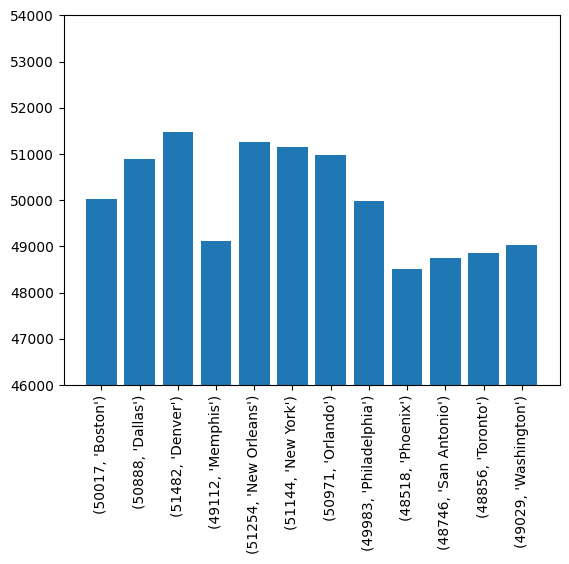

In [ ]:
plt.bar(range(12), np.array(list(normed_odds.values())).sum(axis=1))
plt.xticks(range(12), [(wins, team) for wins, team in zip(np.array(list(normed_odds.values())).sum(axis=1), list(normed_odds.keys()))], rotation=90)
plt.ylim((46000, 54000))
plt.show()

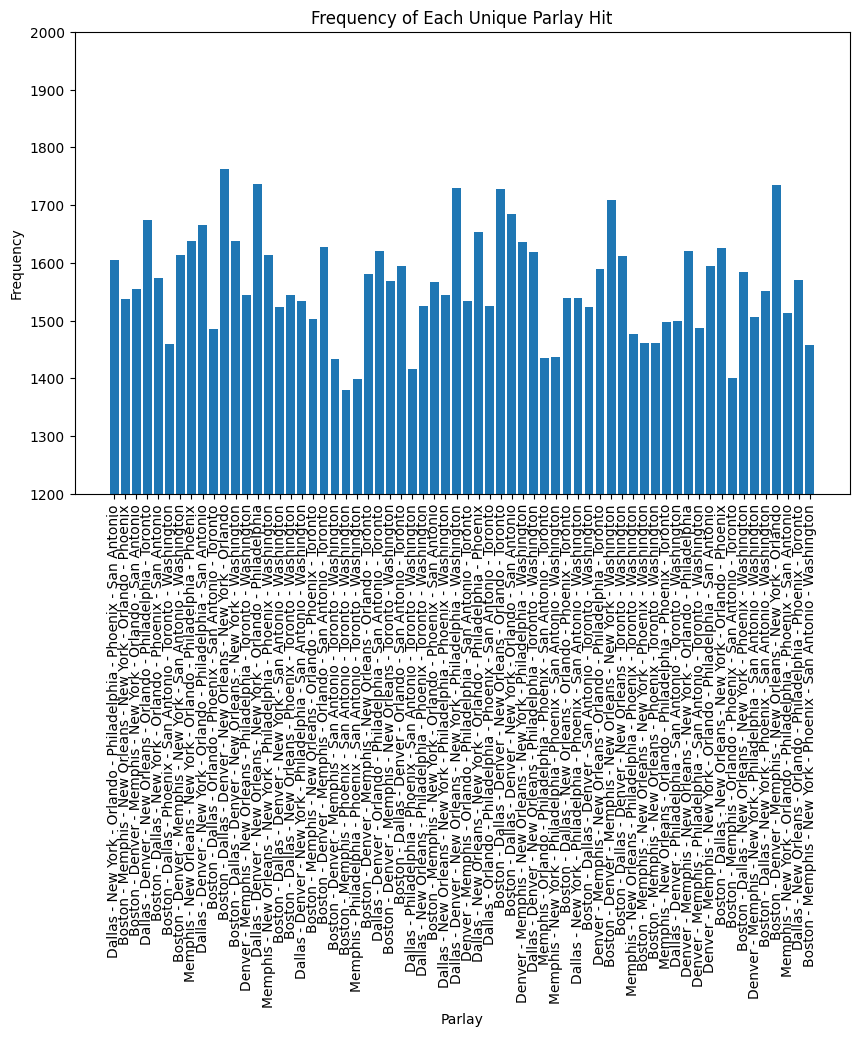

In [ ]:
from collections import Counter

# Normalize each parlay by sorting (to ensure consistent ordering)
normalized_parlays = [' - '.join(sorted(parlay)) for parlay in parlays]

# Count the frequency of each parlay
parlay_counts = Counter(normalized_parlays)

# Separate the parlays and their counts for plotting
ps, counts = zip(*parlay_counts.items())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(ps, counts)
plt.xlabel('Parlay')
plt.ylabel('Frequency')
plt.title('Frequency of Each Unique Parlay Hit')
plt.xticks(rotation=90)  # Rotate labels for readability
plt.ylim((1200, 2000))
plt.show()


In [ ]:
# Assuming parlay_data is your list of parlays
normalized_parlays = [' - '.join(sorted(parlay)) for parlay in parlays]
parlay_counts = Counter(normalized_parlays)

# Sort parlays by frequency (most common first)
sorted_parlays = parlay_counts.most_common()

total_hits = sum(parlay_counts.values())
cumulative_hits = 0
required_parlays = []

for parlay, count in sorted_parlays:
    required_parlays.append(parlay)
    cumulative_hits += count
    if cumulative_hits >= total_hits / 6:
        break
print("Smallest list of parlays to capture 17% of hits:")
print(len(required_parlays))
print(len(sorted_parlays))
for p in required_parlays:
    print(p)



Smallest list of parlays to capture 17% of hits:
10
64
Boston - Dallas - Denver - New Orleans - New York - Orlando
Dallas - Denver - New Orleans - New York - Orlando - Philadelphia
Boston - Denver - Memphis - New Orleans - New York - Orlando
Dallas - Denver - New Orleans - New York - Philadelphia - Washington
Boston - Dallas - Denver - New Orleans - Orlando - Toronto
Boston - Denver - Memphis - New Orleans - New York - Washington
Boston - Dallas - Denver - New York - Orlando - San Antonio
Dallas - Denver - New Orleans - Orlando - Philadelphia - Toronto
Dallas - Denver - New York - Orlando - Philadelphia - San Antonio
Dallas - New Orleans - New York - Orlando - Philadelphia - Phoenix


In [20]:
from sqlalchemy import create_engine

# Database credentials and details
username = 'postgres'
password = 'F8l1i0nt$t0ne!'
host = 'nba.chuweugicfu6.us-east-2.rds.amazonaws.com'
port = '5432'
database = 'nba'

# Example for PostgreSQL, change the dialect as per your RDS database engine
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{username}')

In [18]:
import pandas as pd
df = pd.read_pickle('dataframe.pkl')


In [21]:
df.to_sql('test', con=engine, if_exists='replace', index=False)


OperationalError: ignored